# Setting Limits
1) Make cuts on $E_e$
2) Make cuts on background (1 shower, 0 tracks)
3) Make cuts on $\cos(\theta_\text{NuMI})$ for both
4) Set limits
    1) For the fixed $M_\chi/M_{A'}$ case
    2) For the fixed $M_\chi$ case
    

In [1]:
import os
import uproot3 as up3
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyhf
import sys
sys.path.append("../")
#from src import *
from src.data import load_root_file
from src.transforms import add_cos_theta_signal
from src.PoT_scalling import pot_scale

dm_types = ["scalar", "fermion"]
RUN1_MICROBOONE_POT = 2e20

In [2]:
# Cuts
E_e_min = 0.1 # GeV from ...
cos_theta_numi_cuts = [0.6, 0.8] # should probably study this AFTER E_e cut

In [3]:
def two_bin_hist(df : pd.DataFrame, pot_scale : float, cos_theta_numi_cuts : list):
    """Generate 2 bin histogram for the given data frame
    bin1 = cut gives background
    bin2 = cut gives signal

    Args:
        df (pandas.DataFrame): dataframe containing a column with "cos_theta_NuMI
        pot_scale (float): pmax * pot_run_1 / pot_sample
        cos_theta_numi_cuts (list): [cut lower, cut upper] (such that we get signal with these cuts)

    Returns:
        (np.array, np.array) : [counts background, counts signal], [bin edges]
    """
    

    hist = np.zeros(2)
    hist[0] = pot_scale * len(df[(df["cos_theta_numi"] < cos_theta_numi_cuts[0]) | (df["cos_theta_numi"] > cos_theta_numi_cuts[1])])
    hist[1] = pot_scale * len(df[(df["cos_theta_numi"] >= cos_theta_numi_cuts[0]) & (df["cos_theta_numi"] <= cos_theta_numi_cuts[1])])
    return hist, np.array([0,0.5,1])

### Backgrounds

In [4]:
CUT_SHOWERS = 1
CUT_TRACKS = 0

vars = ['reco_asso_showers', 'reco_asso_tracks', 'reco_shower_dirx', 'reco_shower_diry', 'reco_shower_dirz', 'reco_shower_energy_max']
bkg_path = "../data/root/background/"

def cuts(df : pd.DataFrame) -> pd.DataFrame:
    # for now, 0 tracks, 1 shower
    df = df[df['reco_asso_showers'] == CUT_SHOWERS]
    df = df[df['reco_asso_tracks'] == CUT_TRACKS]
    return df


bkg_incryo_df = pd.concat([load_root_file("run1_NuMI_nu_overlay_with_weights.root", bkg_path, vars, cuts, 10_000, 'vertex_tree;269'), 
                          load_root_file("run1_NuMI_nu_overlay_with_weights.root", bkg_path, vars, cuts, 10_000, 'vertex_tree;268')])
bkg_dirt_df = pd.concat([load_root_file("run1_NuMI_dirt_with_weights.root", bkg_path, vars, cuts, 10_000, 'vertex_tree;127'),
                        load_root_file("run1_NuMI_dirt_with_weights.root", bkg_path, vars, cuts, 10_000, 'vertex_tree;126')])
bkg_beamoff_df = load_root_file("run1_NuMI_offbeam_full_set_sp.root", bkg_path, vars, cuts, 10_000, "singlephotonana")

bkg_total = pd.concat([bkg_incryo_df, bkg_dirt_df, bkg_beamoff_df])
print(len(bkg_total))

/home/alex/projects/DarkElectronScatter/notebooks/../src/data.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat((df, df_temp))
/home/alex/projects/DarkElectronScatter/notebooks/../src/data.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat((df, df_temp))
/home/alex/projects/DarkElectronScatter/notebooks/../src/data.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer e

25623


In [5]:
# get the 2-bin histogram for the background
# pot_run1 / pot_file
bkg_pot_df = pd.DataFrame(columns=["bkg_type", "pot_ratio"])
bkg_pot_df.loc[0] = ["nu",(1/2.35e+21)*2.2e+20]
bkg_pot_df.loc[1] = ["dirt",(1/1.55e+21)*2.2e+20]
bkg_pot_df.loc[2] = ["offbeam",0.98*(5736147/9186361.390000)]
bkg_hist_incryo, bkg_edges_incryo = two_bin_hist(bkg_incryo_df, bkg_pot_df[bkg_pot_df["bkg_type"]=="nu"]["pot_ratio"], cos_theta_numi_cuts)
bkg_hist_dirt, bkg_edges_dirt = two_bin_hist(bkg_dirt_df, bkg_pot_df[bkg_pot_df["bkg_type"]=="dirt"]["pot_ratio"], cos_theta_numi_cuts)
bkg_hist_beamoff, bkg_edges_beamoff = two_bin_hist(bkg_beamoff_df, bkg_pot_df[bkg_pot_df["bkg_type"]=="offbeam"]["pot_ratio"], cos_theta_numi_cuts)

bkg_hist_total = bkg_hist_incryo + bkg_hist_dirt + bkg_hist_beamoff
bkg_edges_total = bkg_edges_incryo

/tmp/ipykernel_35520/3949741570.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hist[0] = pot_scale * len(df[(df["cos_theta_numi"] < cos_theta_numi_cuts[0]) | (df["cos_theta_numi"] > cos_theta_numi_cuts[1])])
/tmp/ipykernel_35520/3949741570.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hist[1] = pot_scale * len(df[(df["cos_theta_numi"] >= cos_theta_numi_cuts[0]) & (df["cos_theta_numi"] <= cos_theta_numi_cuts[1])])


### Fixed $M_\chi/M_{A'}$

In [15]:
data_dir = "../data/root/BdNMC/"

n_evts_df = []
#costhetanumihist = np.zeros(50)
#bins = np.linspace(-1,1,51)

for dm_type in dm_types:
    for file in os.listdir(data_dir+dm_type+"/"):
        with up3.open(data_dir+dm_type+"/"+file) as f:
            if f.keys() == []:
                continue

            df = f["elecron_tree"].pandas.df()
            df = df[df["electron_energy"] >= 0.1] # Cut on Energy
            n_electrons = len(df)
            df = add_cos_theta_signal(df)
            #costhetanumihist += np.histogram(df["cos_theta_numi"], bins=bins)[0]
            pot = f["pot_tree"]["tot_pot"].array()
            pmax = f["pot_tree"]["pmax"].array()

            dt = file.split("_")[5].strip(".root")
            ma = file.split("_")[3]
            meson_t = file[0:3]

            pot_sc = (RUN1_MICROBOONE_POT / pot) * pmax
            hist, edges = two_bin_hist(df, pot_sc, cos_theta_numi_cuts)
            n_evts_df.append([dm_type, dt, ma, meson_t, hist, edges])

n_evts_df = pd.DataFrame(n_evts_df, columns=["dm_type", "dt", "ma", "meson_t", "hist", "edges"])
#display(n_evts_df)


# Need to add pi0 and eta files together

get_other_meson_dict = {"pi0":"eta", "eta":"pi0"}

merged_df = pd.DataFrame(columns=["dm_type", "dt", "ma", "hist", "edges"])

i = 0
for signal in n_evts_df.iterrows():
    # okay so we cannot assume we always have a pi0 and eta file
    # so we need to check if the other file exists
    dt = signal[1]["dt"]
    ma = signal[1]["ma"]
    meson_t = signal[1]["meson_t"]
    dm_type = signal[1]["dm_type"]
    other_meson_t = get_other_meson_dict[meson_t]
    
    # look for the other meson in the n_evts_df, add it, and remove it
    other_meson = n_evts_df[(n_evts_df["meson_t"]==other_meson_t) & (n_evts_df["dm_type"]==dm_type) & (n_evts_df["dt"]==dt) & (n_evts_df["ma"]==ma)]
    if len(other_meson) == 0:
        # no matching meson found
        merged_df.loc[i] = signal[1]
        i += 1
    else:
        # add the two histograms together
        hist = signal[1]["hist"] + other_meson["hist"].values[0]
        edges = signal[1]["edges"]
        merged_df.loc[i] = [dm_type, dt, ma, hist, edges]
        n_evts_df.drop(other_meson.index, inplace=True) # to avoid duplicates in the merged_df
        i += 1

# plt.stairs(costhetanumihist, bins, fill=True, alpha=0.5, label="NuMI")
# plt.plot([cos_theta_numi_cuts[0], cos_theta_numi_cuts[0]], [0,10000], "r--", label="Signal region")
# plt.plot([cos_theta_numi_cuts[1], cos_theta_numi_cuts[1]], [0,10000], "r--")
# plt.xlabel("cos(theta)")
# plt.ylabel("Events")
# plt.title("cos(theta) distribution")
# plt.legend()
# plt.show()

/tmp/ipykernel_35520/3949741570.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist[0] = pot_scale * len(df[(df["cos_theta_numi"] < cos_theta_numi_cuts[0]) | (df["cos_theta_numi"] > cos_theta_numi_cuts[1])])
/tmp/ipykernel_35520/3949741570.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist[1] = pot_scale * len(df[(df["cos_theta_numi"] >= cos_theta_numi_cuts[0]) & (df["cos_theta_numi"] <= cos_theta_numi_cuts[1])])
/tmp/ipykernel_35520/3949741570.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performi

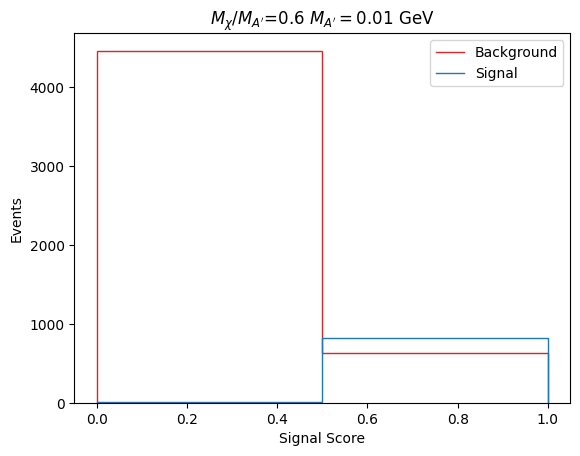

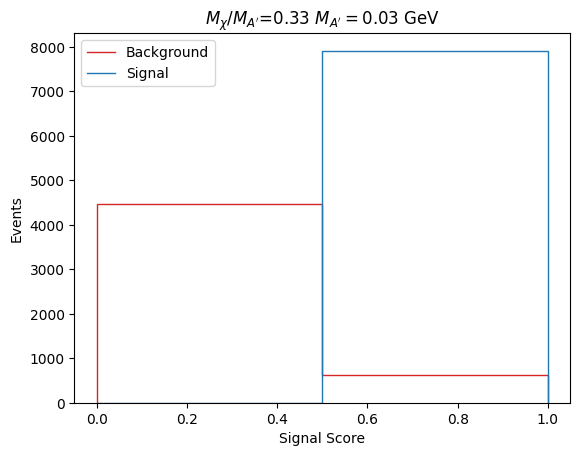

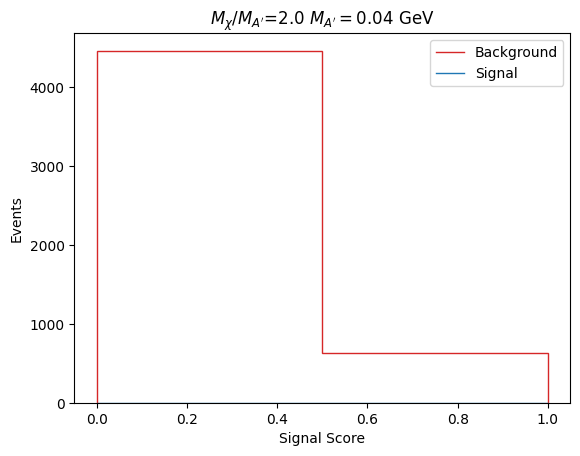

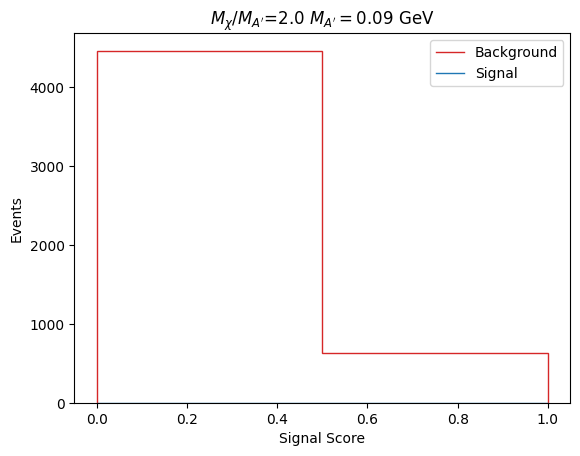

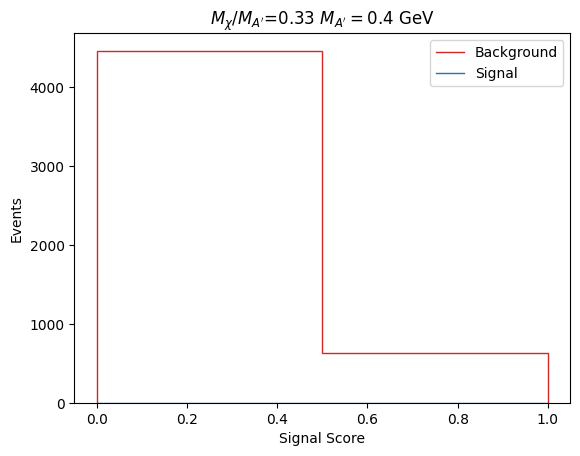

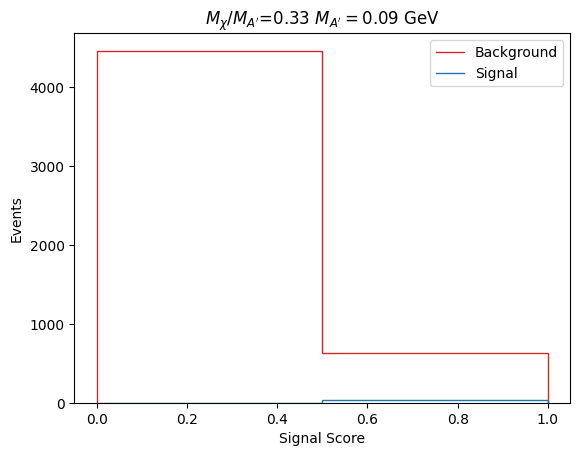

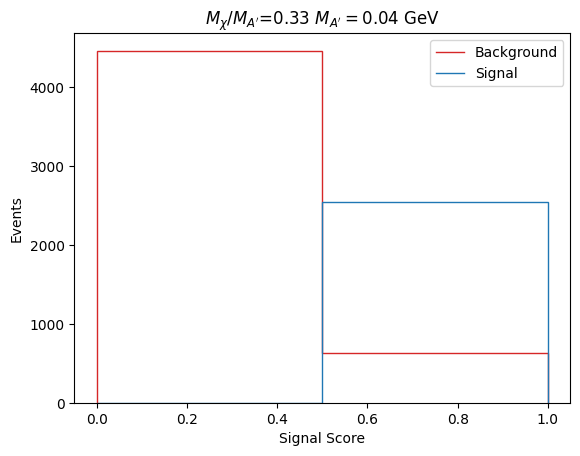

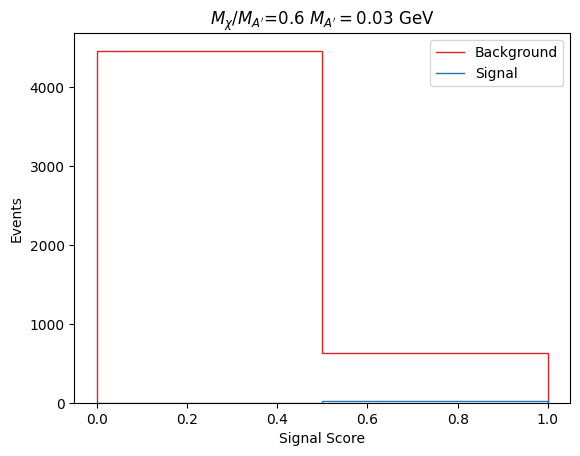

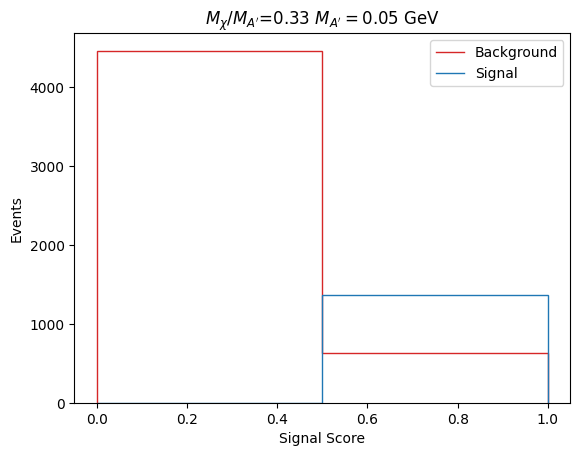

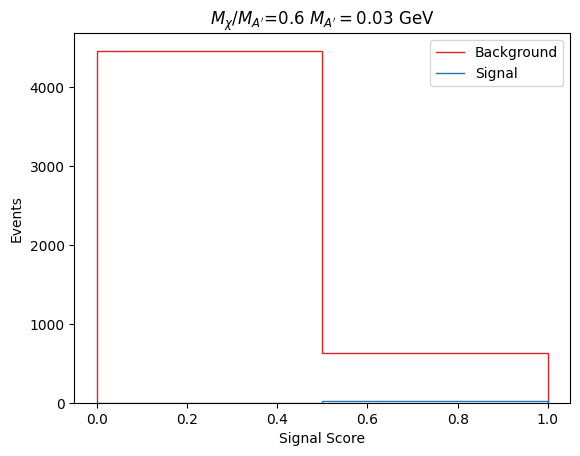

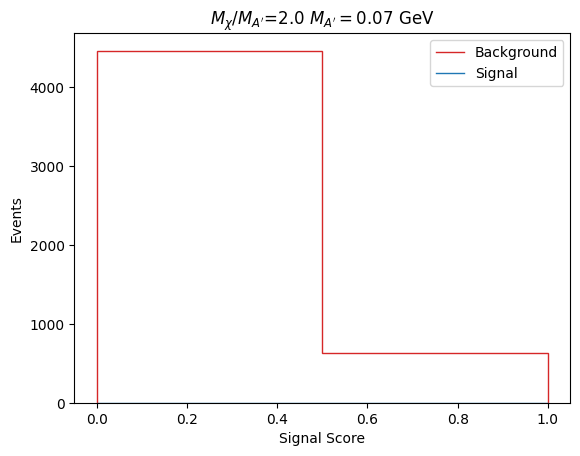

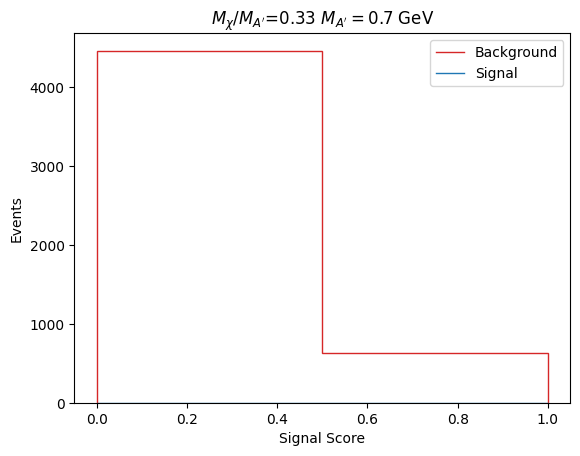

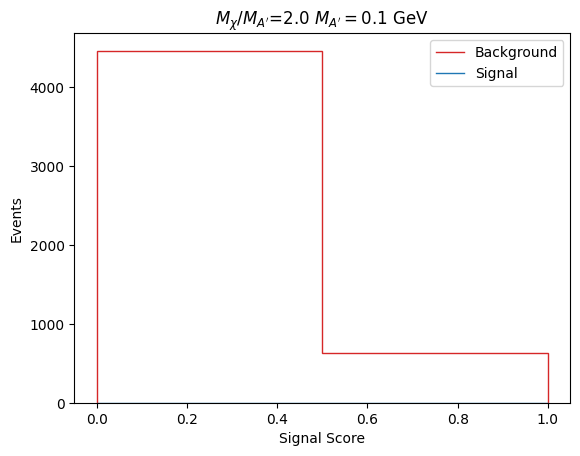

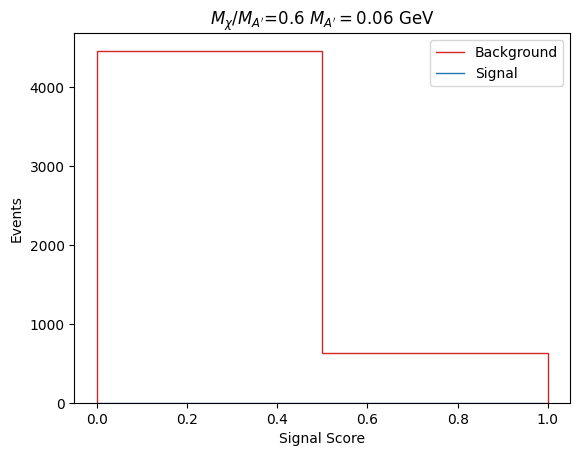

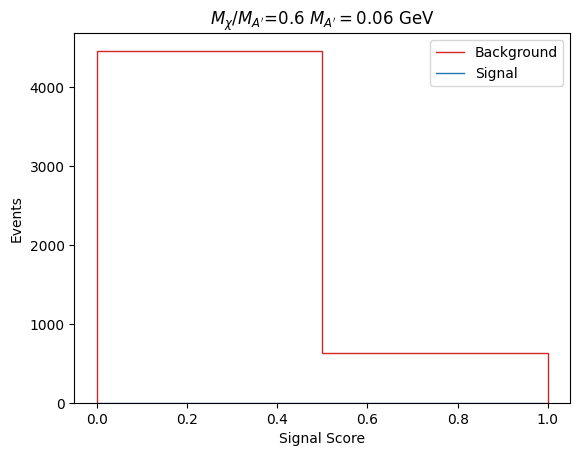

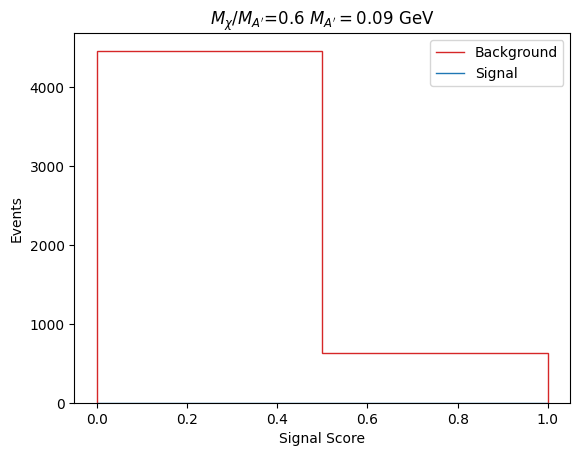

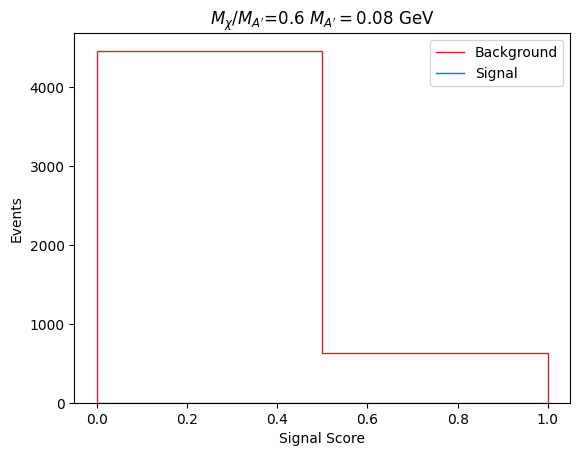

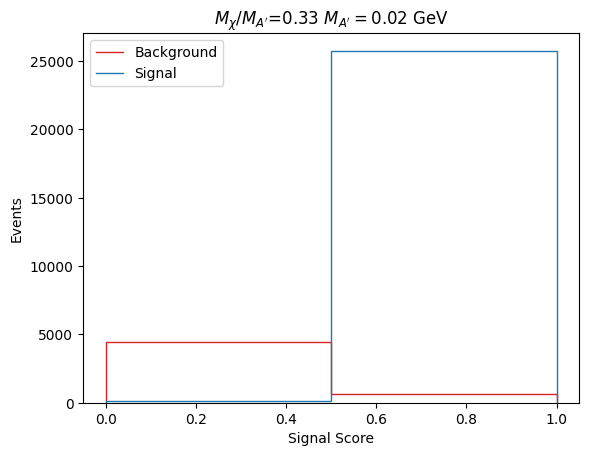

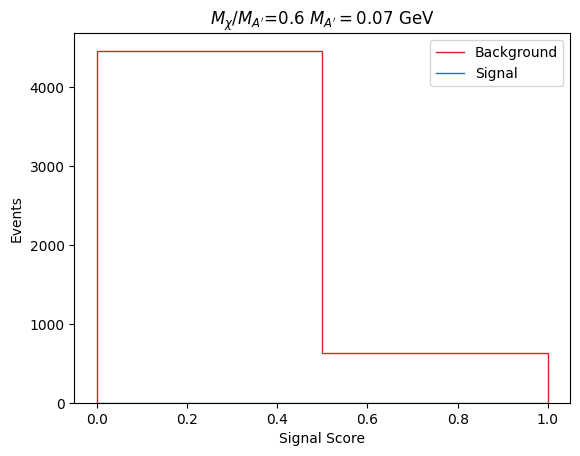

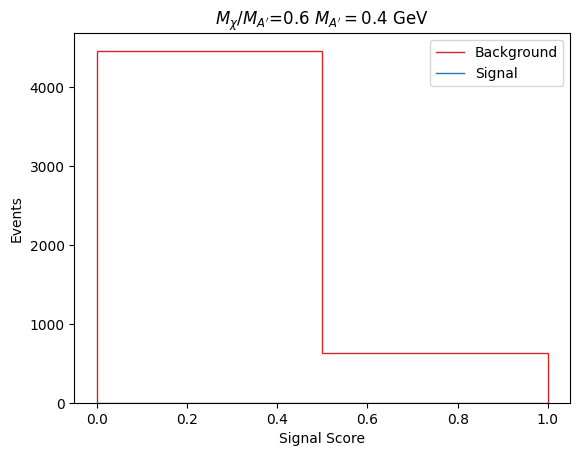

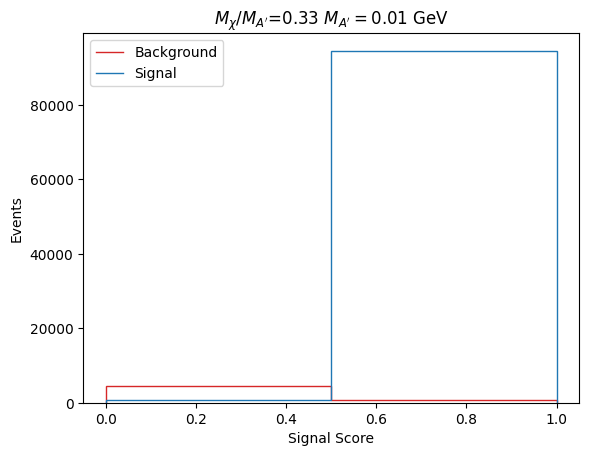

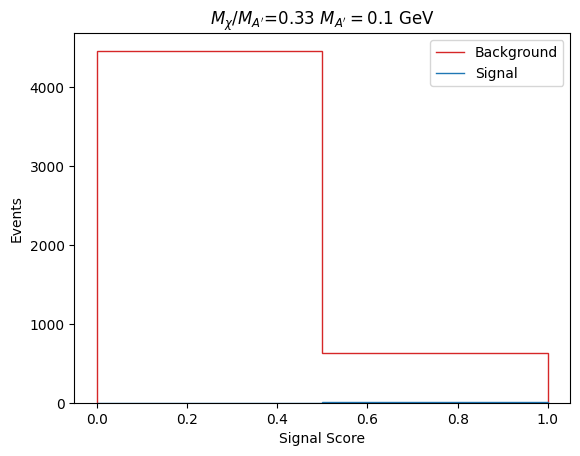

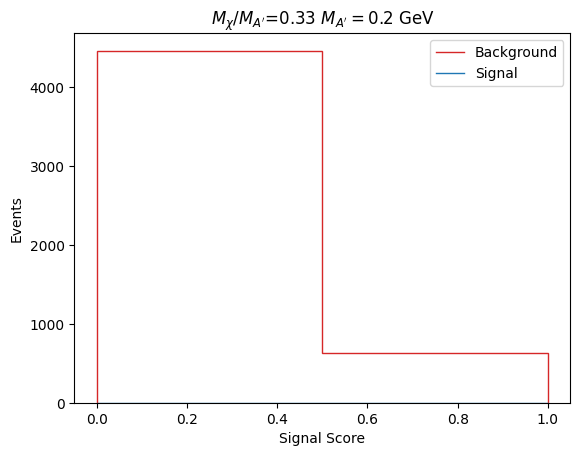

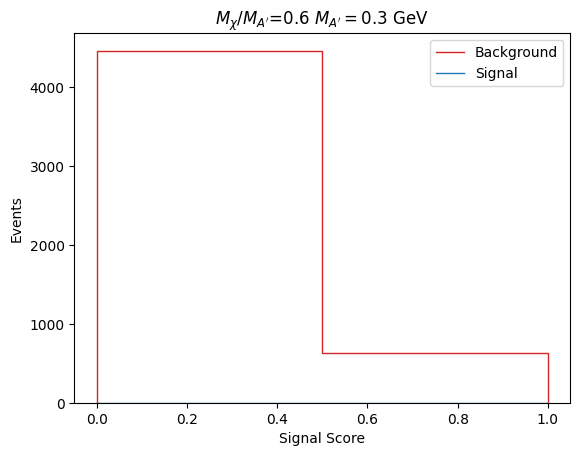

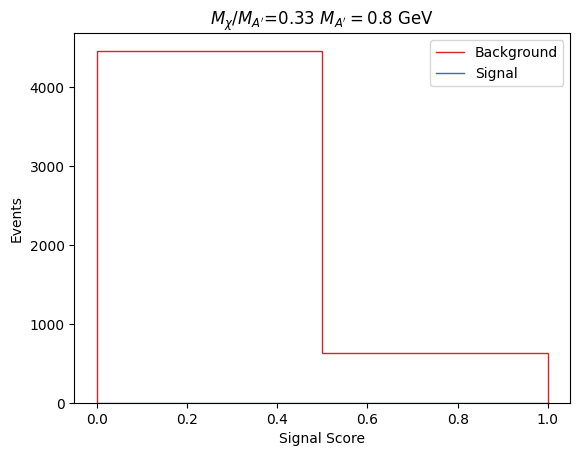

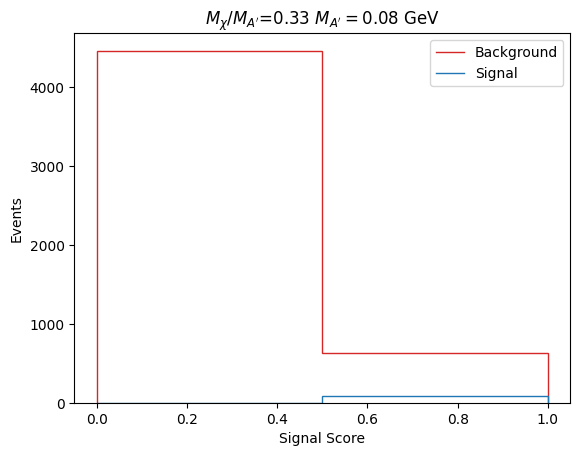

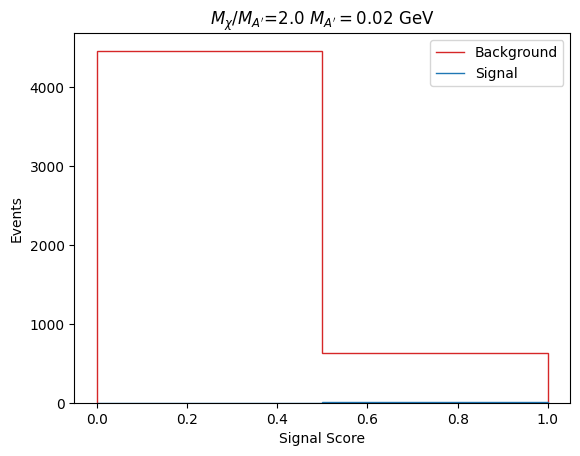

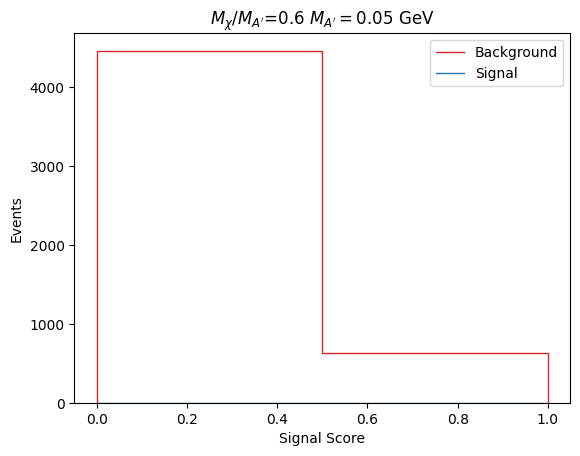

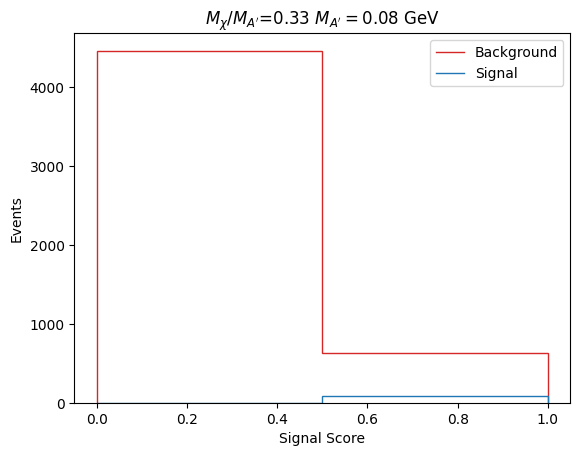

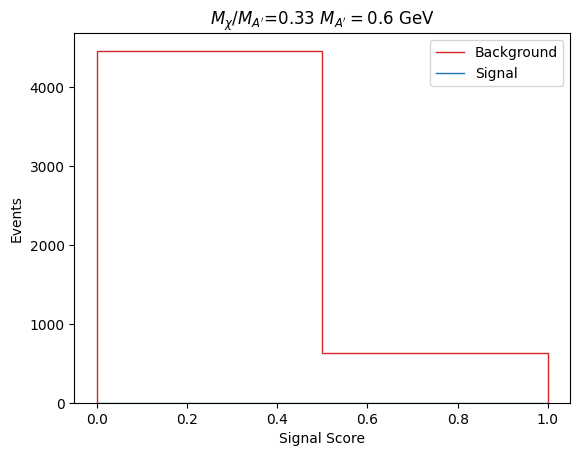

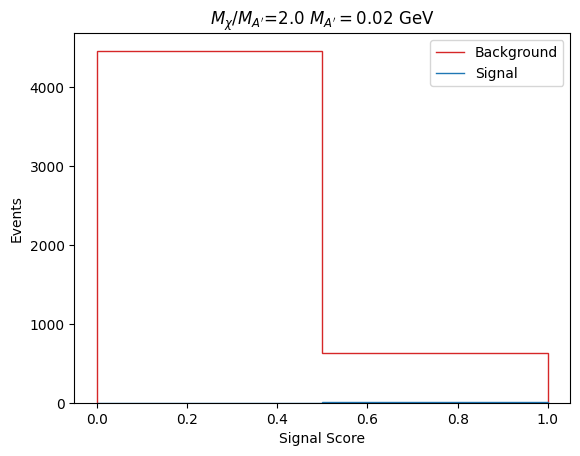

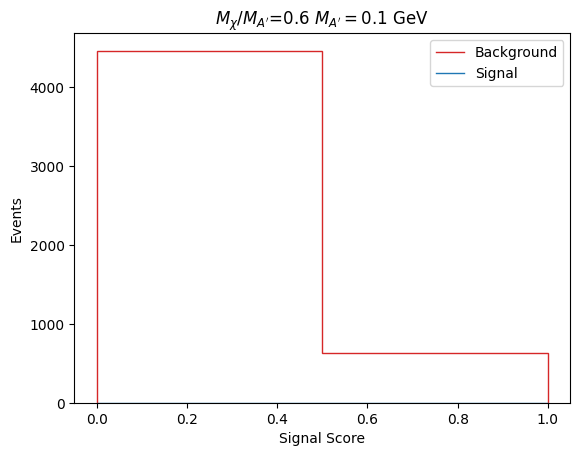

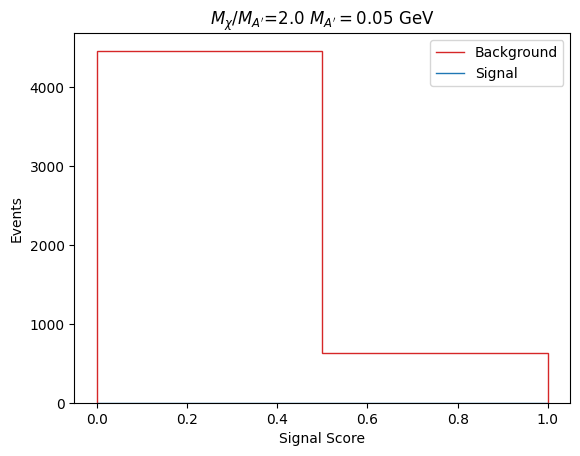

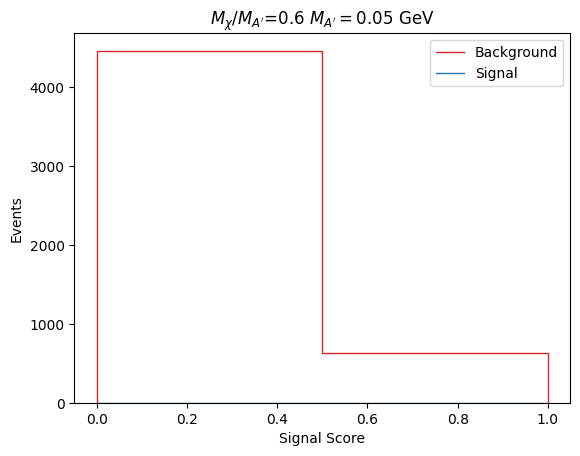

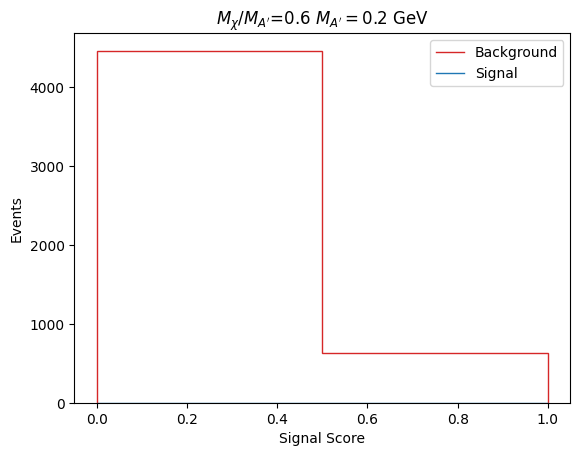

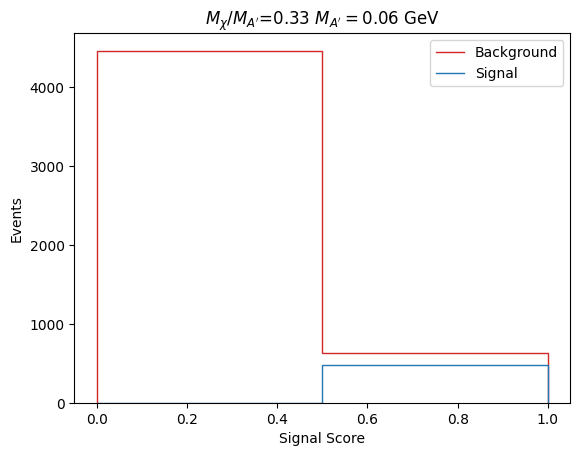

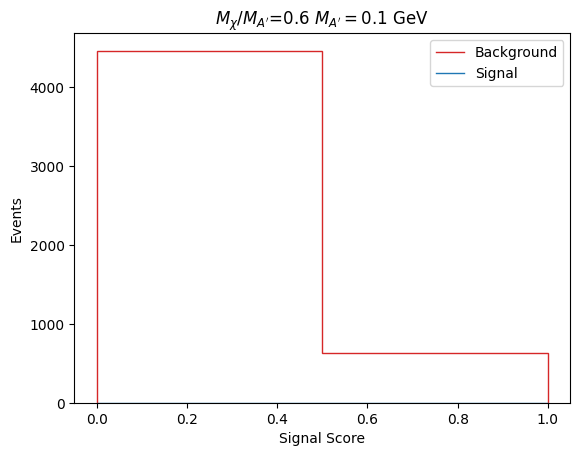

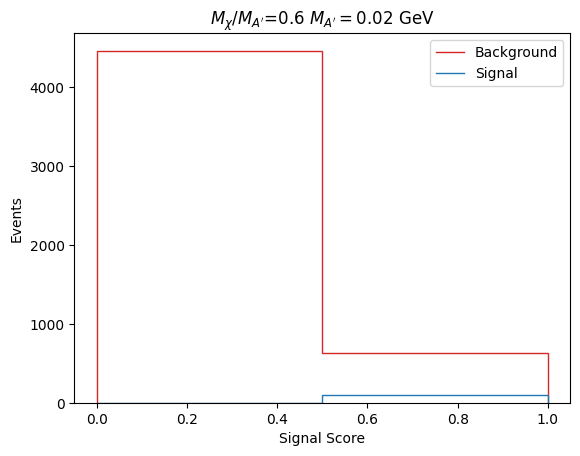

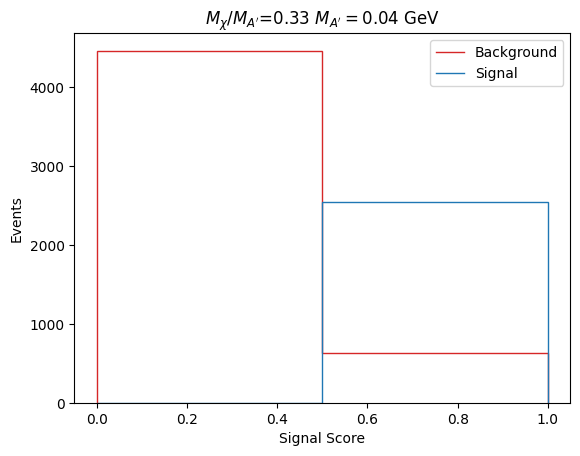

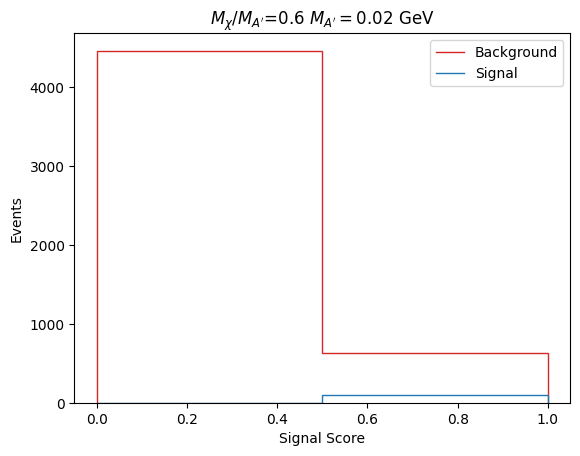

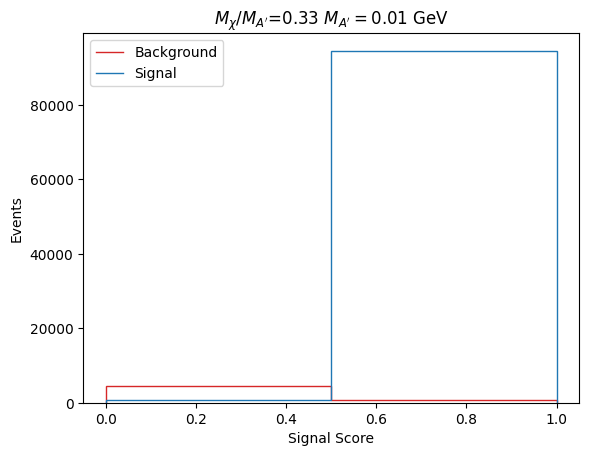

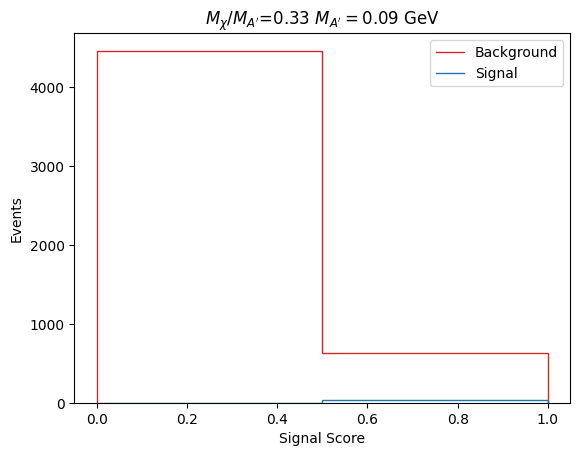

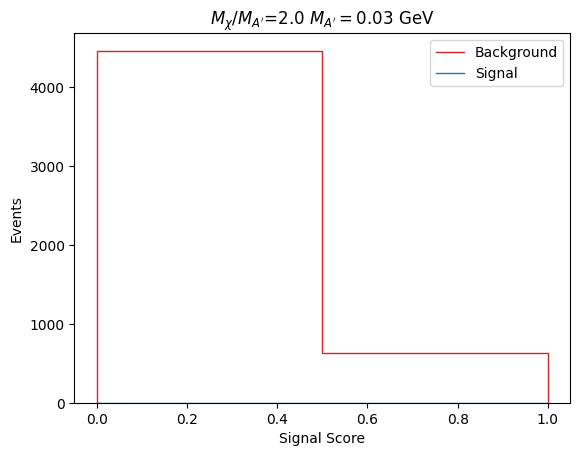

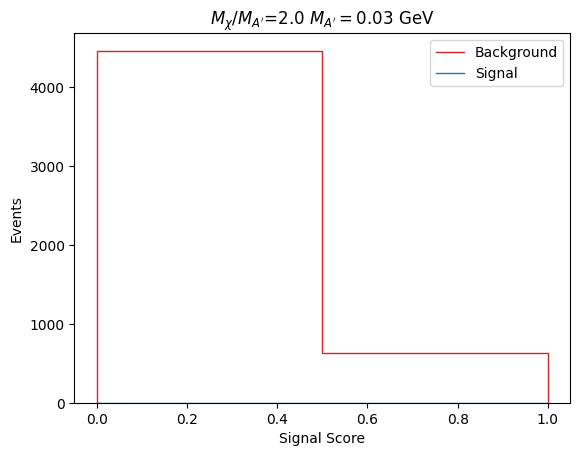

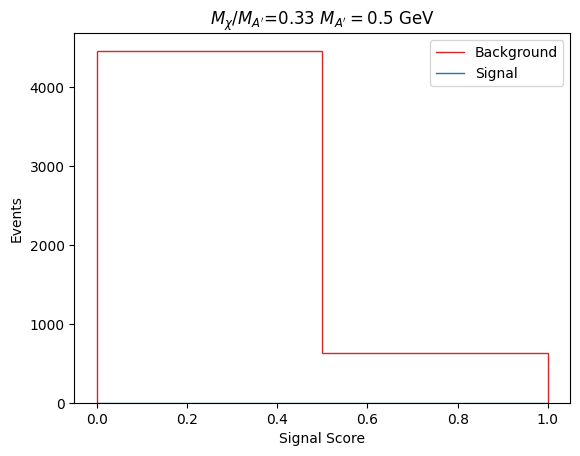

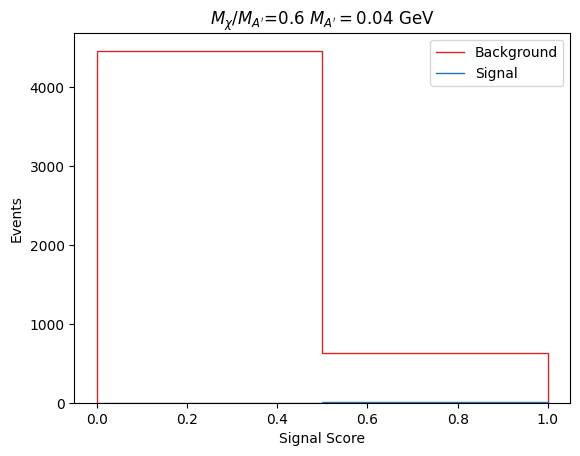

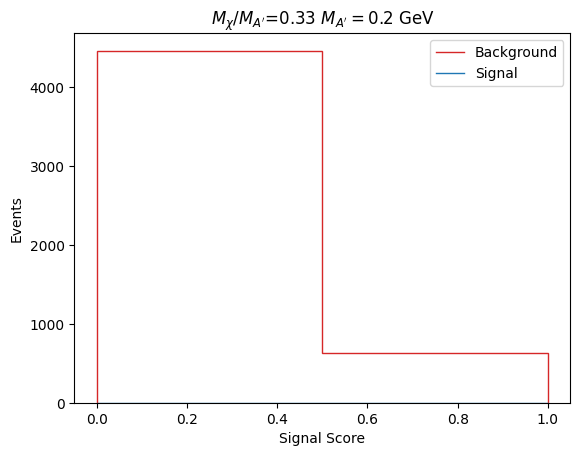

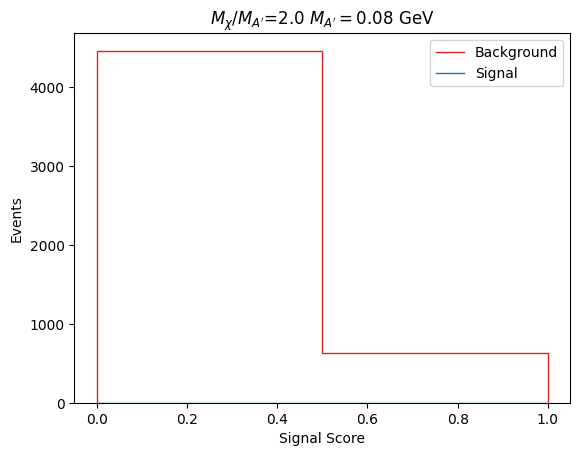

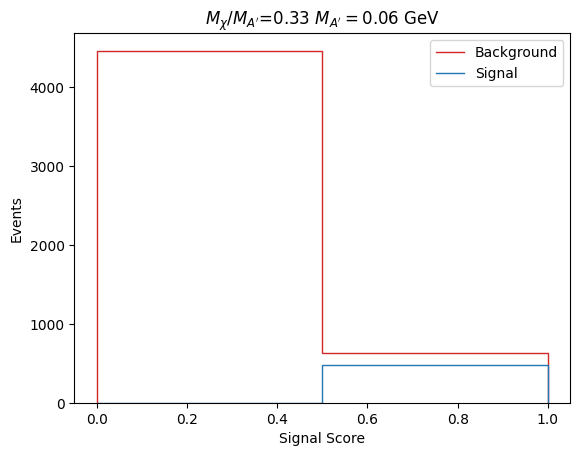

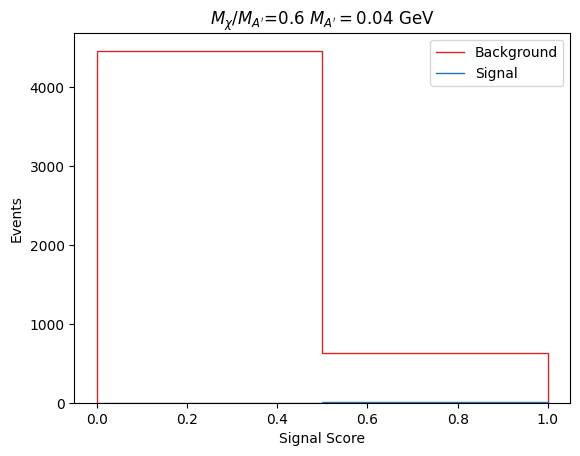

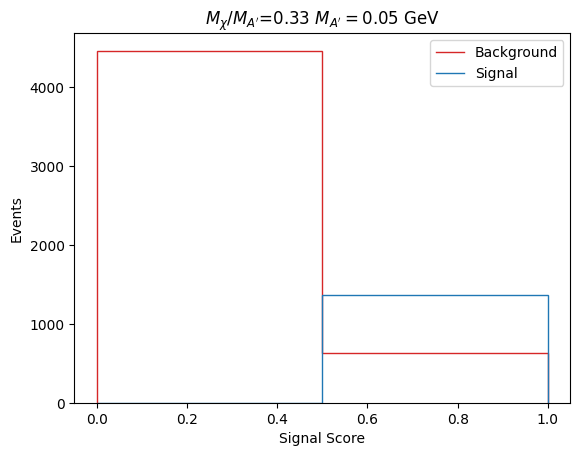

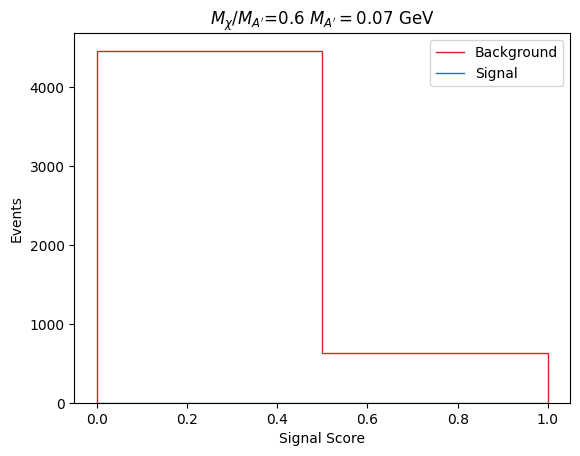

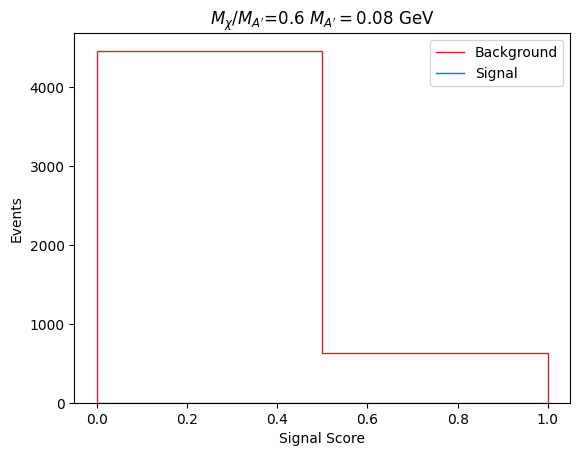

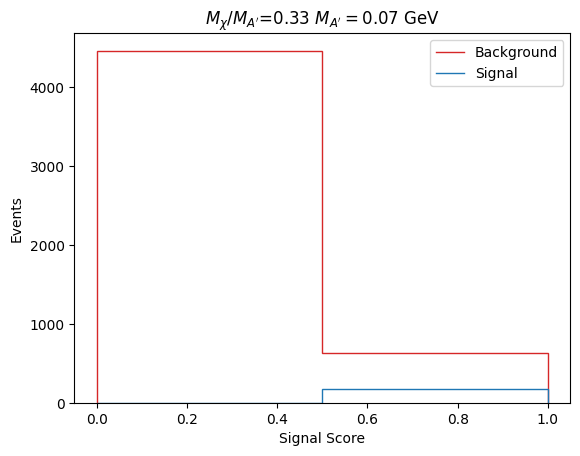

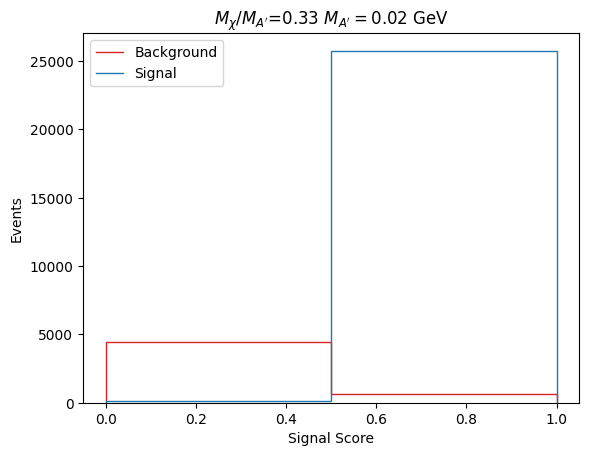

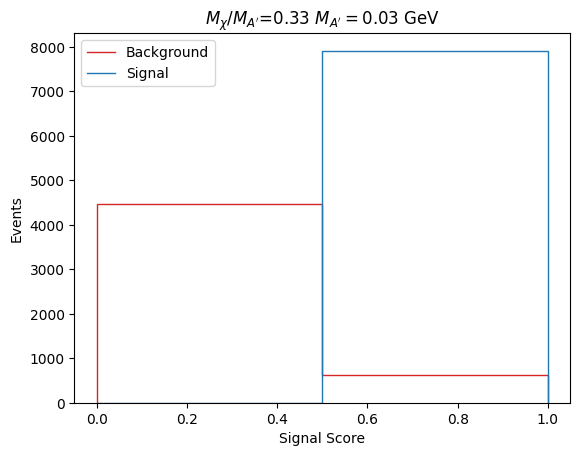

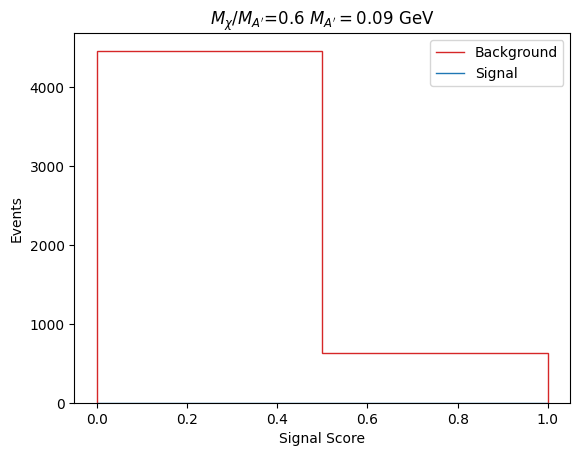

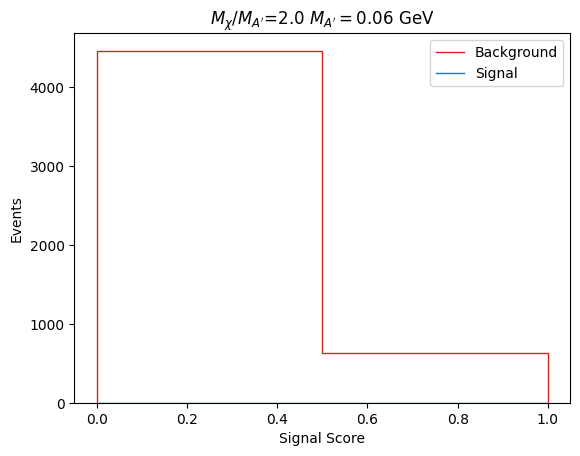

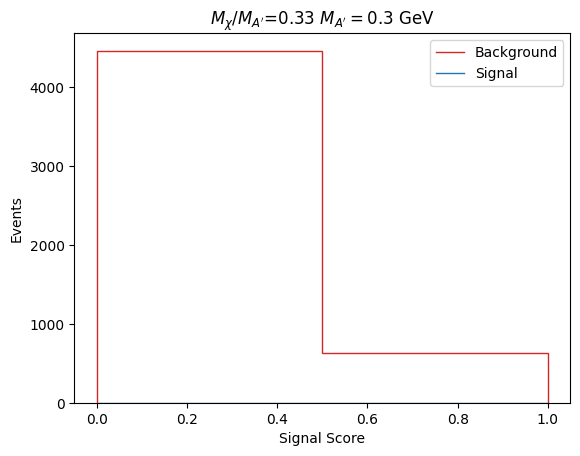

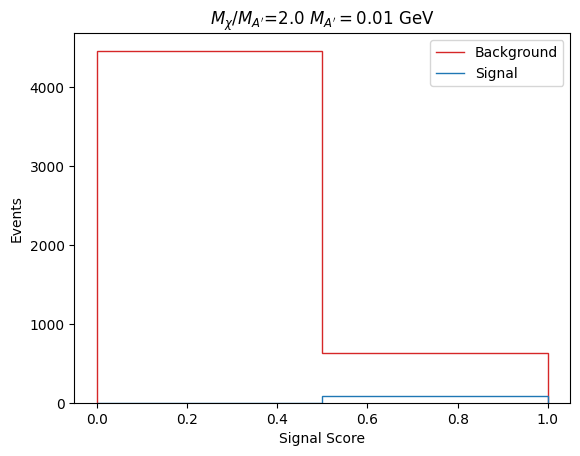

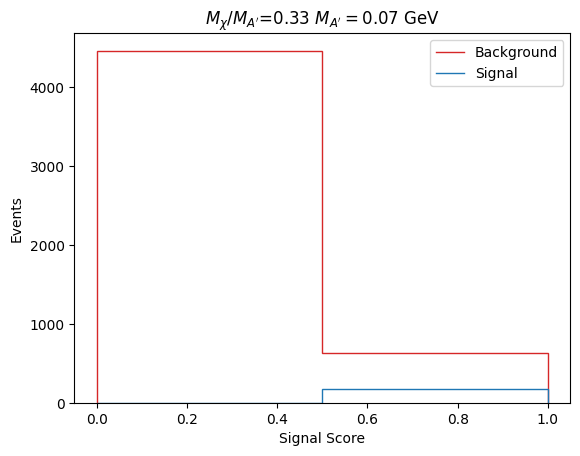

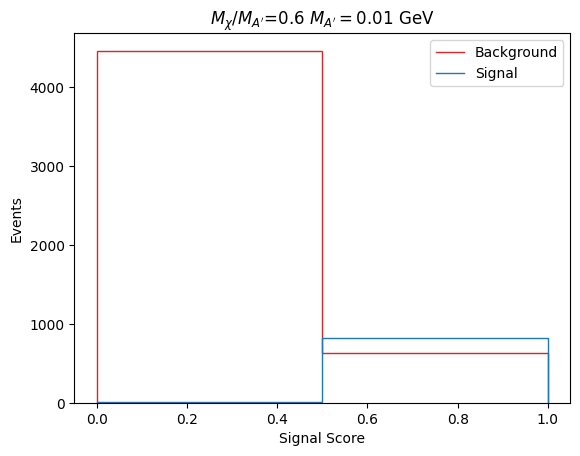

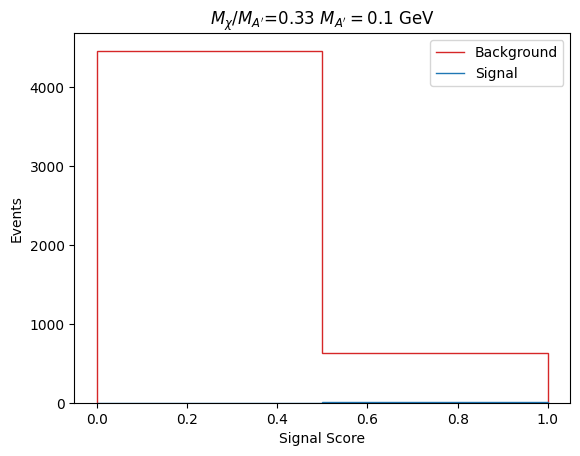

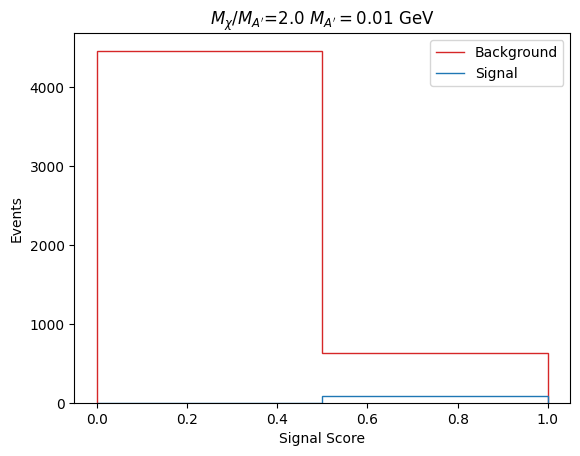

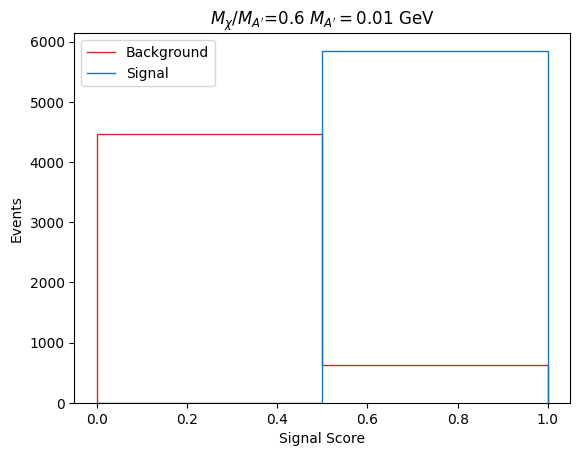

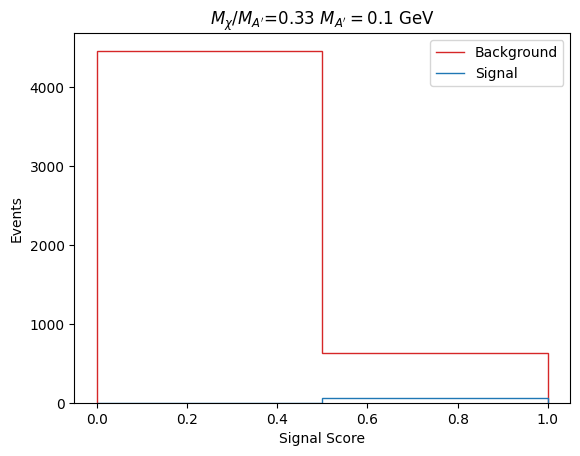

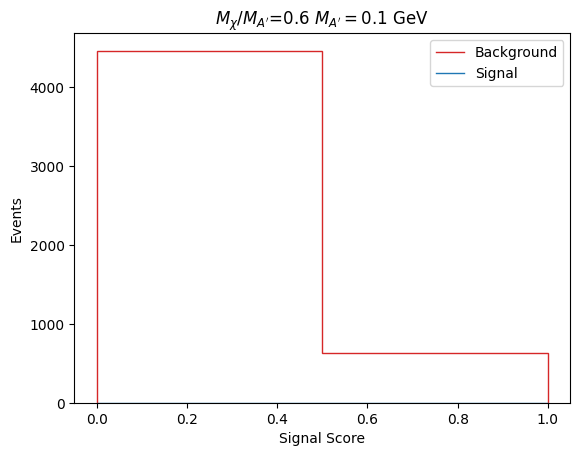

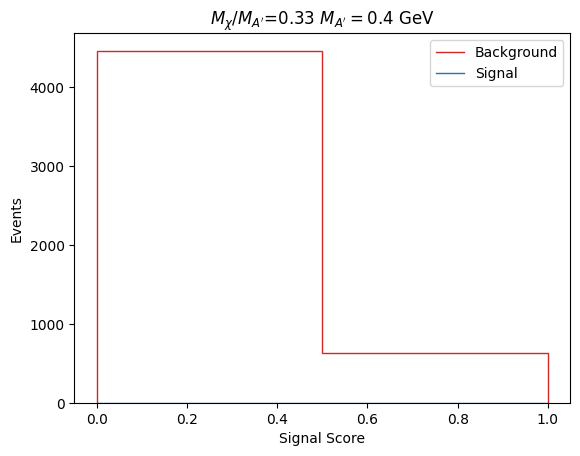

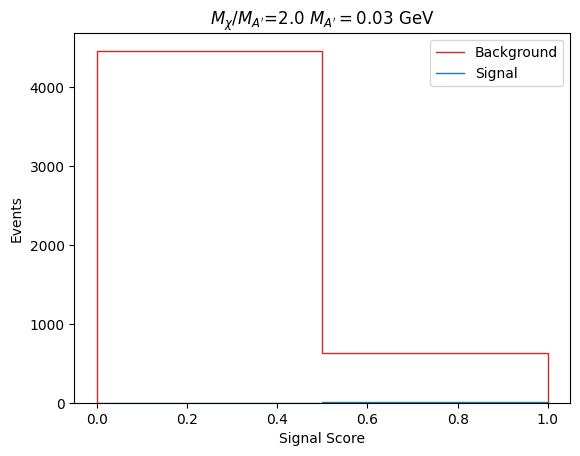

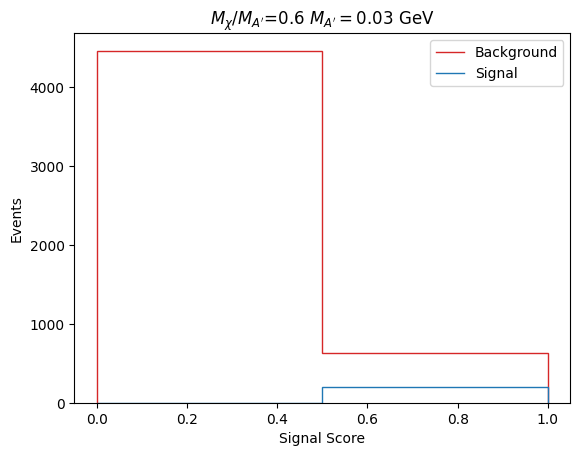

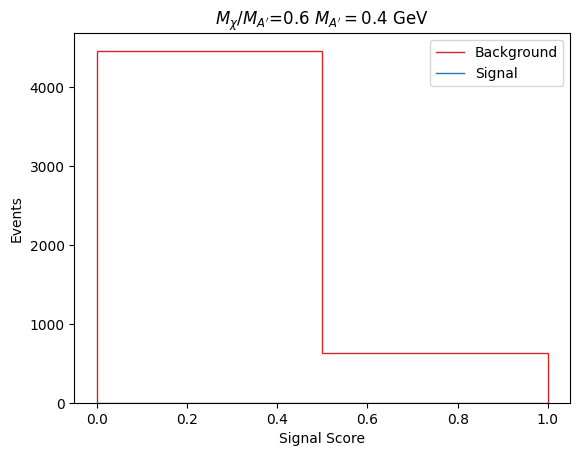

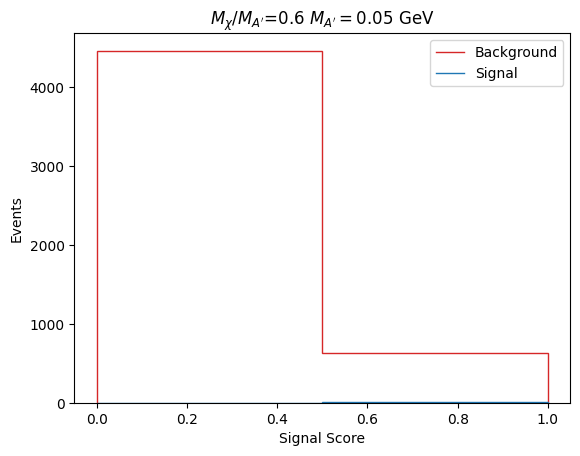

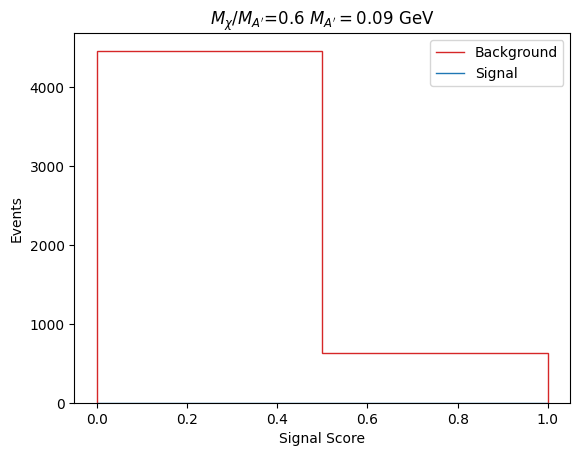

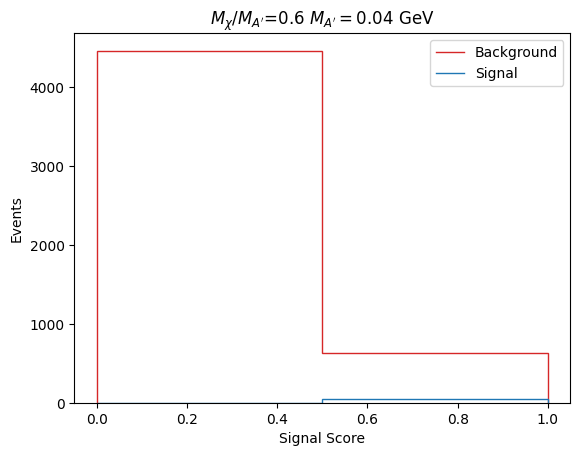

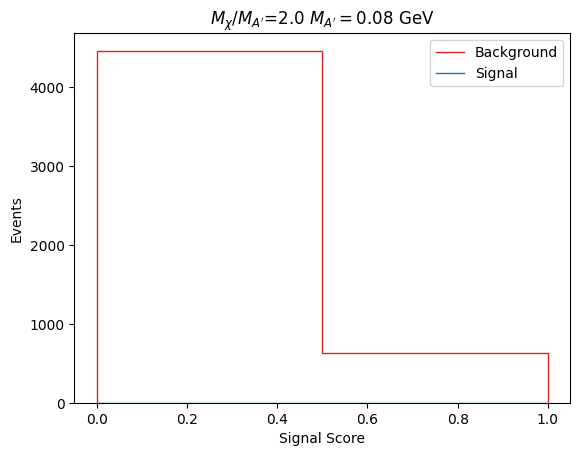

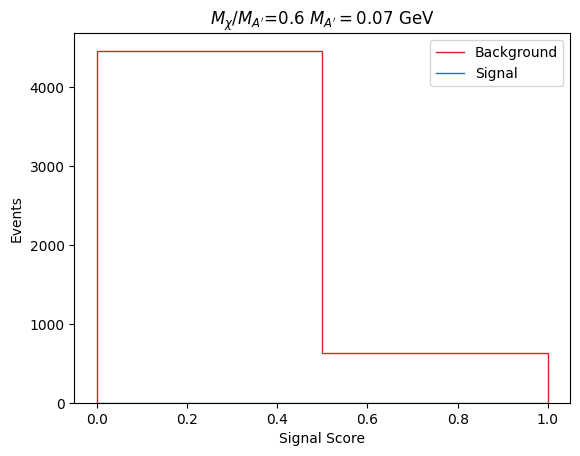

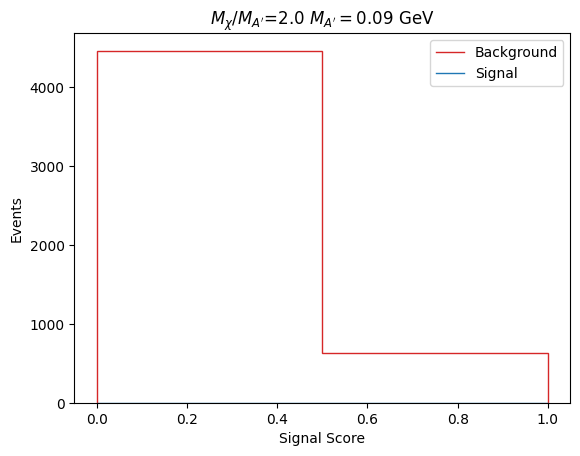

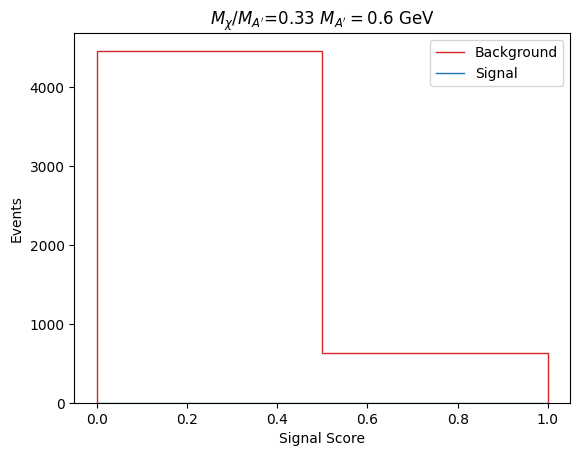

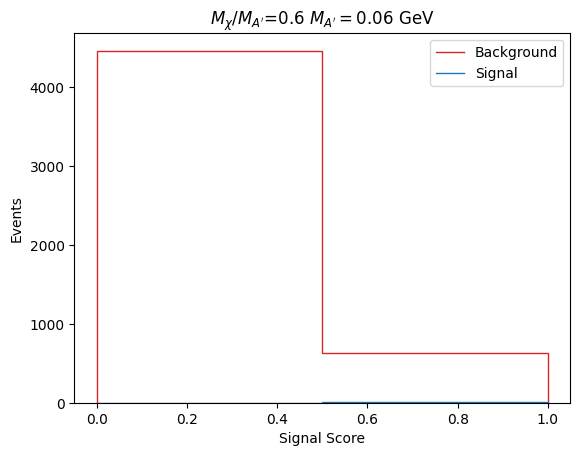

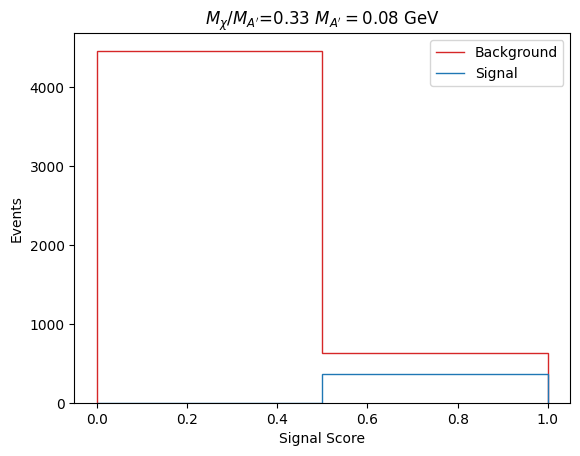

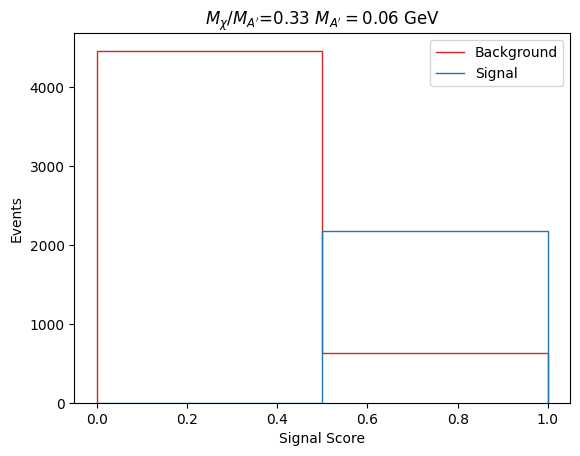

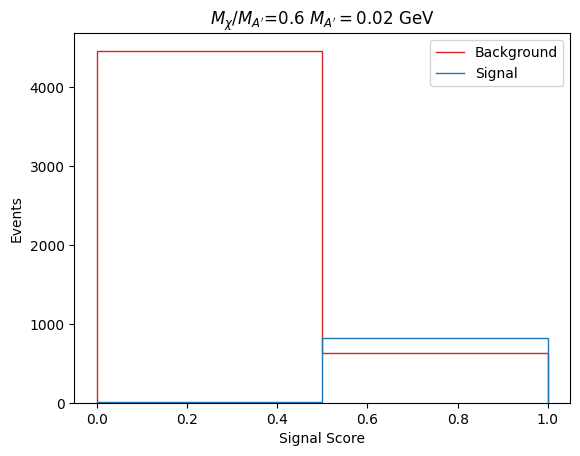

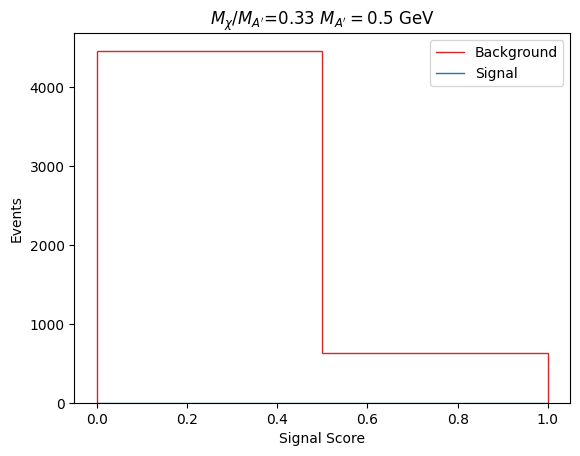

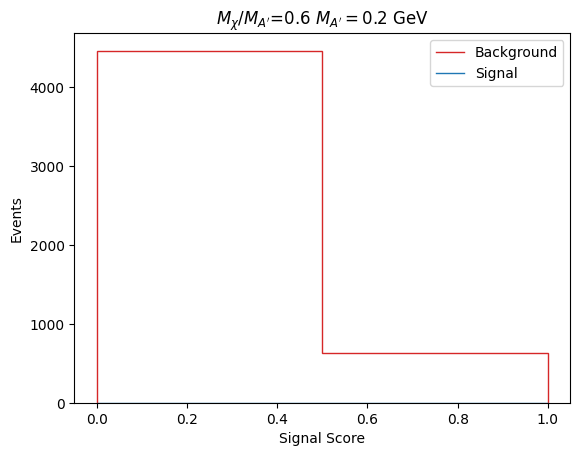

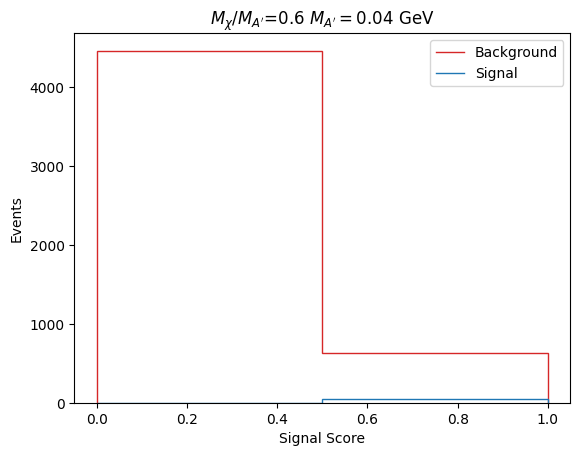

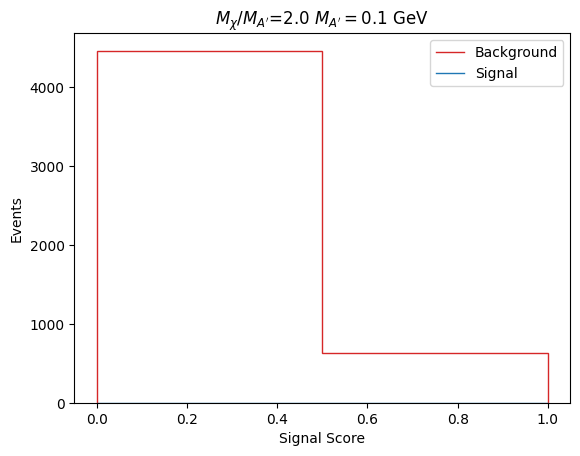

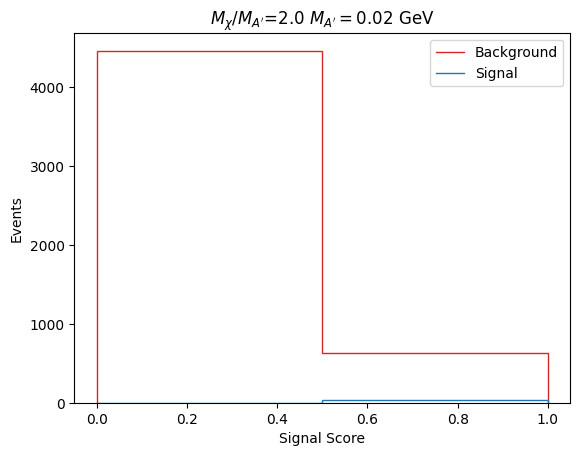

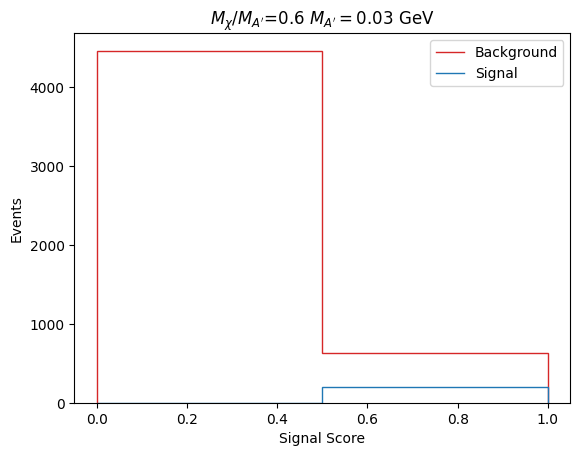

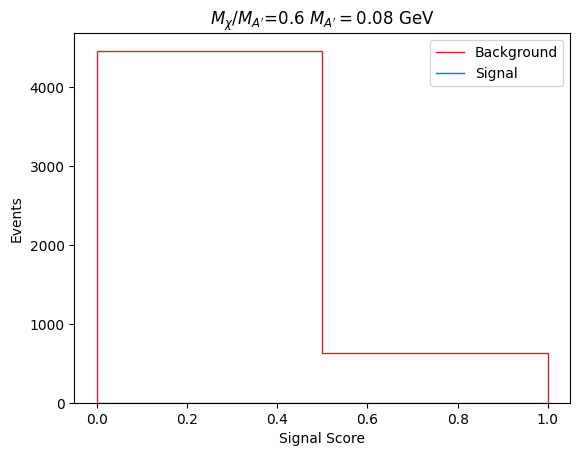

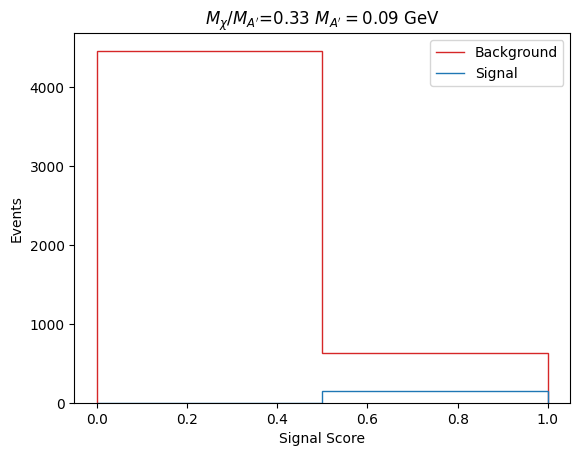

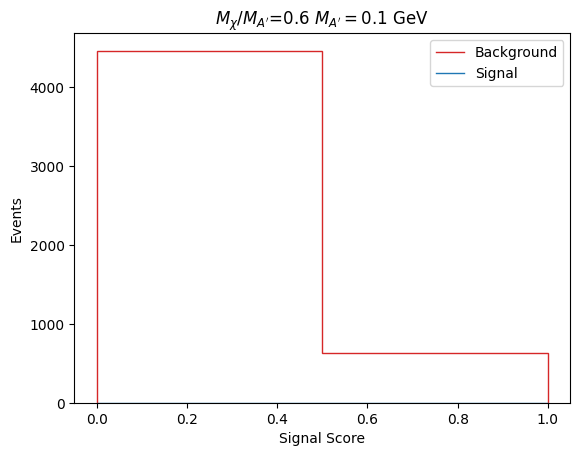

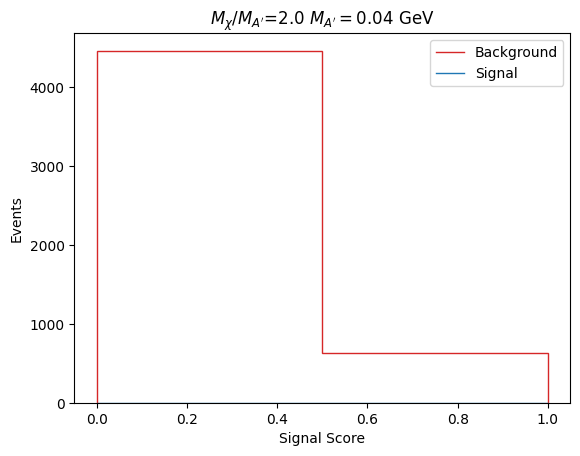

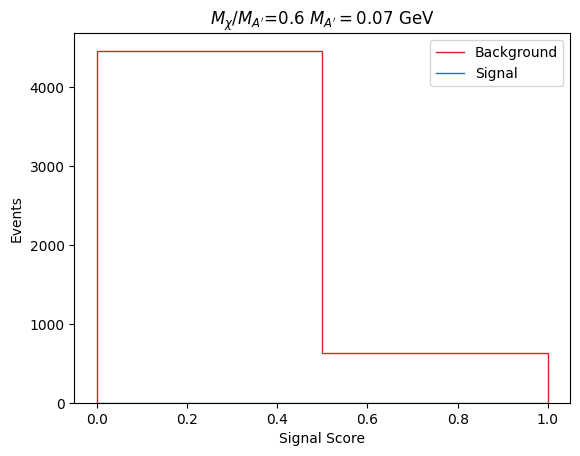

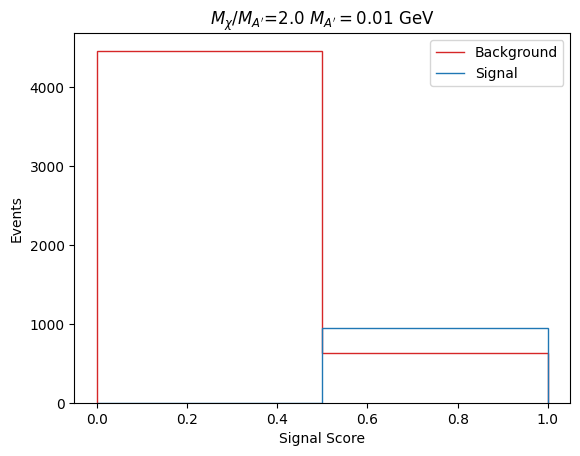

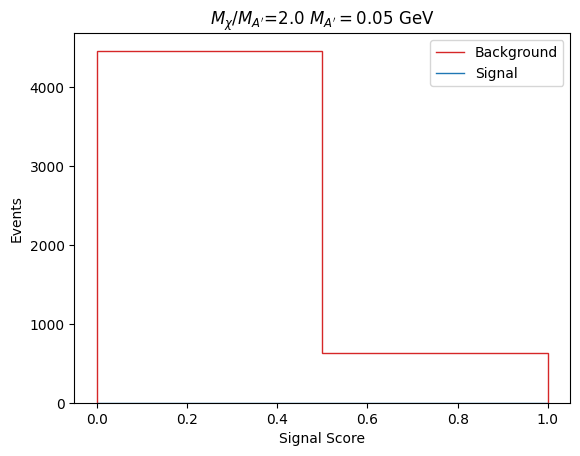

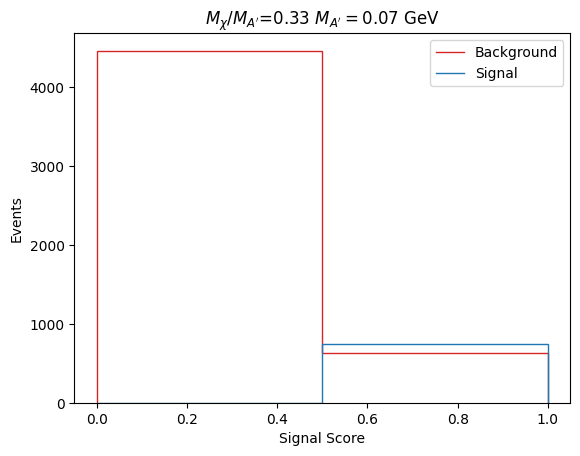

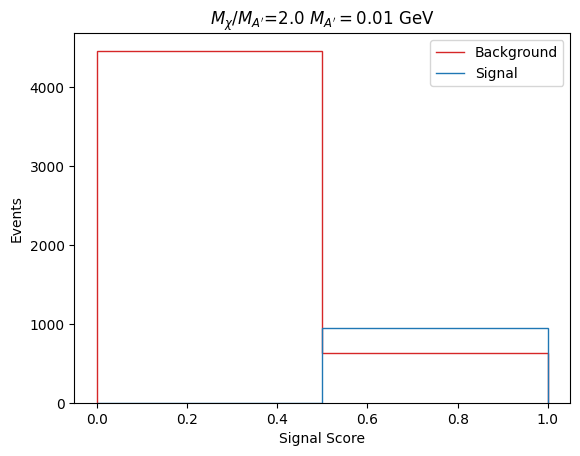

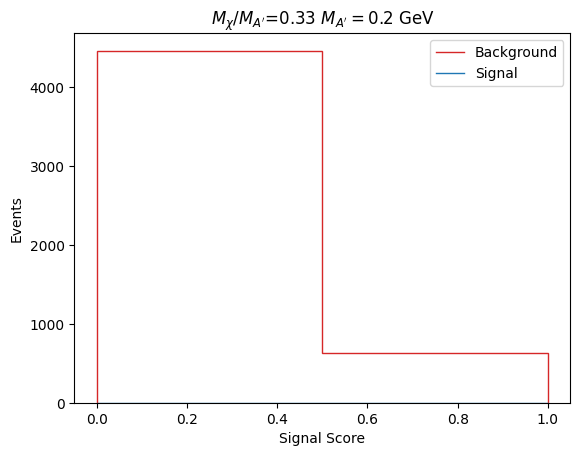

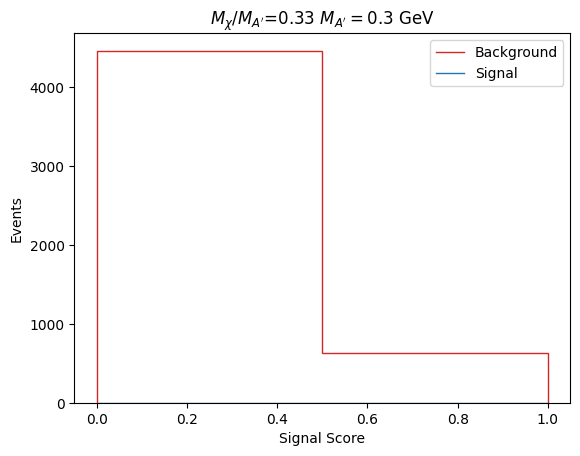

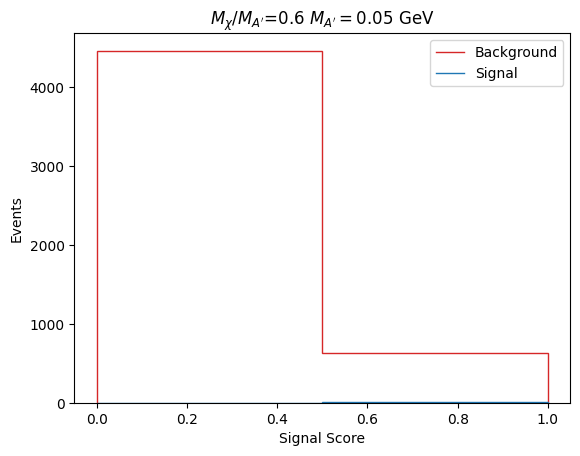

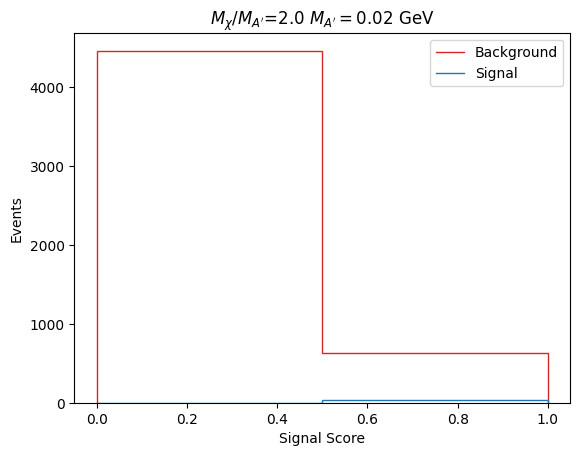

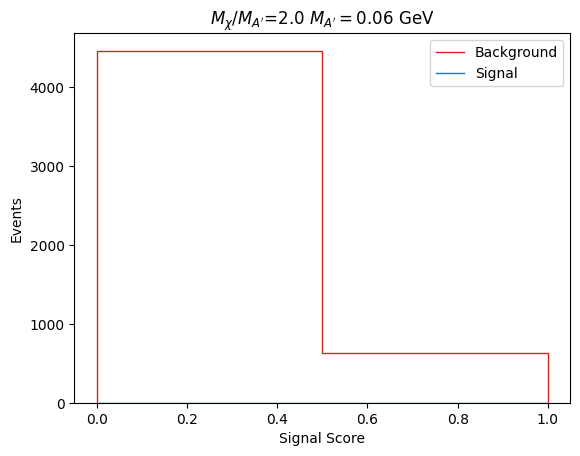

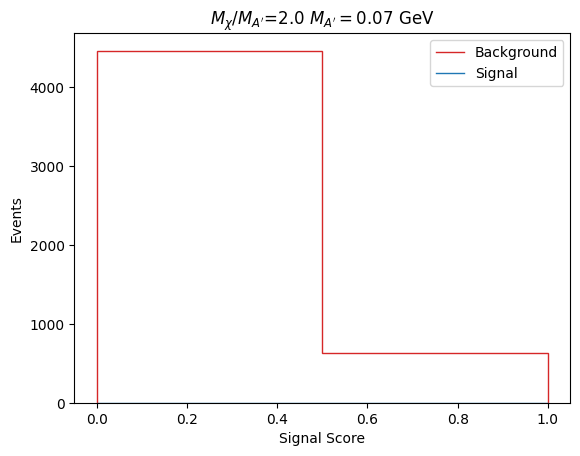

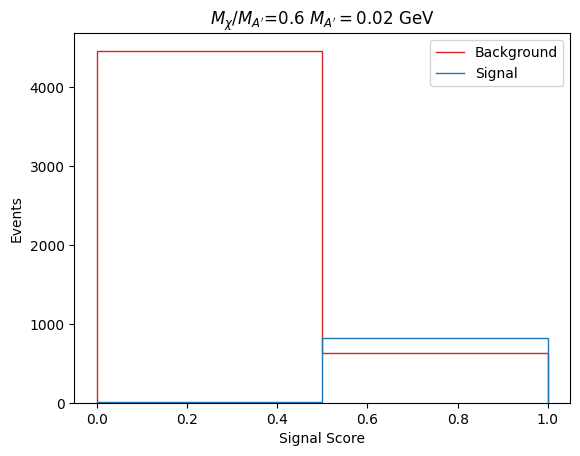

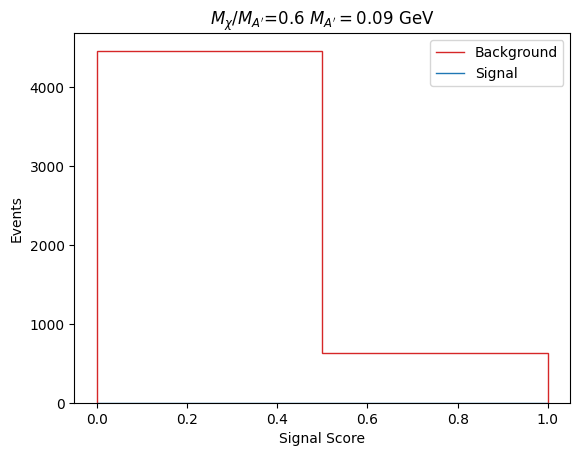

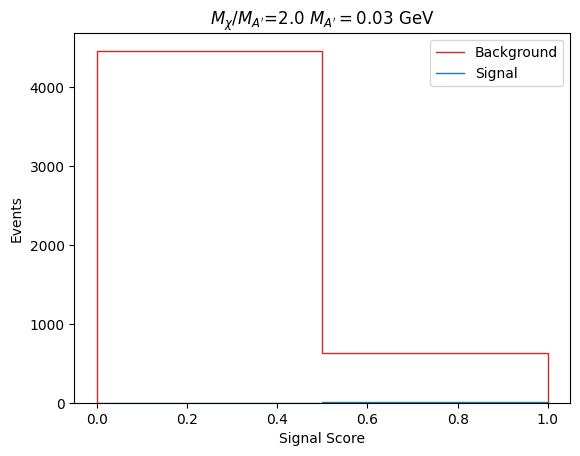

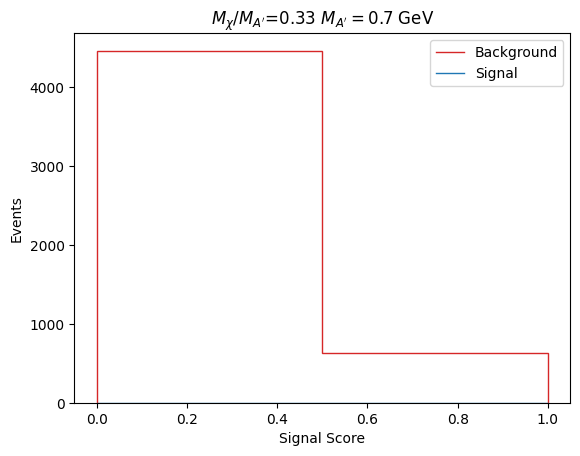

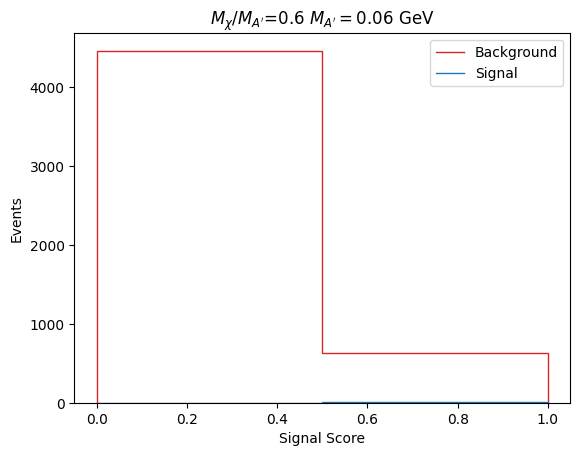

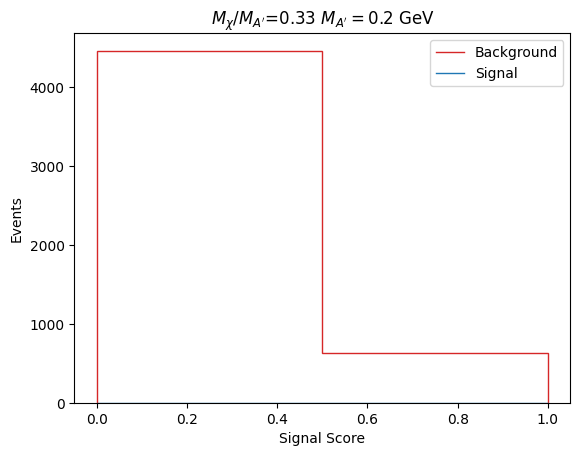

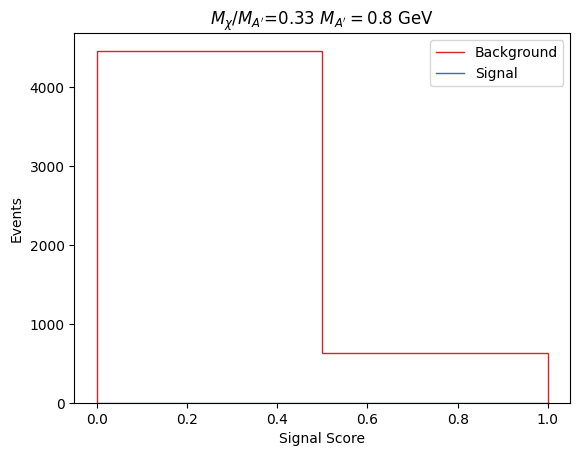

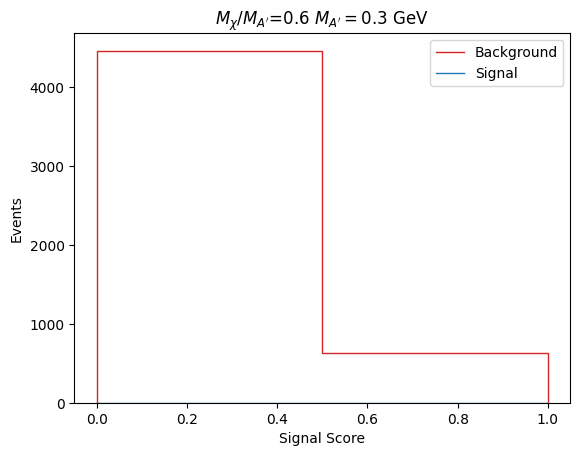

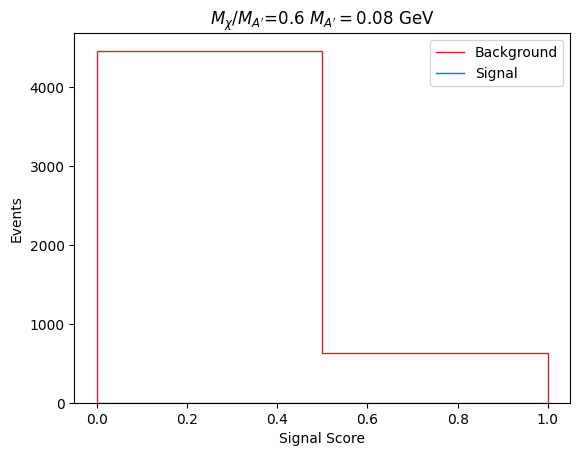

In [16]:
plotting = False
for signal in merged_df.iterrows():
    dt = signal[1]["dt"]
    dm = signal[1]["dm_type"]
    ma = signal[1]["ma"]
    if plotting:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.stairs(bkg_hist_total, bkg_edges_total, label="Background", color="tab:red")
        ax.stairs(signal[1]["hist"], signal[1]["edges"], label="Signal", color="tab:blue")
        ax.legend()
        ax.set(title=r"$M_\chi/M_{A'}$="+signal[1]["dt"]+r" $M_{A'}="+signal[1]["ma"]+"$ GeV", xlabel=r"Signal Score", ylabel="Events")
        plt.savefig("../plots/signal_background_scores/fixed_dt/"+f"{dm}_ma_{ma}_dt_{dt}.png")
        plt.savefig("../plots/signal_background_scores/fixed_dt/"+f"{dm}_ma_{ma}_dt_{dt}.pdf")
        plt.show()
    
    # add the histograms to root files
    with uproot.recreate("../data/root/hist/fixed_dt/"+f"{dm}_ma_{ma}_dt_{dt}.root") as f:
        f["signal"] = signal[1]["hist"], signal[1]["edges"]
        f["background"] = bkg_hist_total, bkg_edges_total


In [17]:
f = uproot.open("../data/root/hist/fixed_dt/scalar_ma_0.04_dt_0.33.root")
s = f["signal"].values()
b = f["background"].values()
print(s, b)

[1.47966971e+00 2.54646889e+03] [4460.33137917  627.17894703]


In [18]:
# set limits
def pyhf_limits(rootfname : str, rootfpath : str, nominal_eps : float = 1e-3, bkg_err : float = 0.1):
    with uproot.open(rootfpath+rootfname+".root") as file:
        total_sig = np.sum(file["signal"].values())
        total_bkg = np.sum(file["background"].values())

        if total_sig == 0:
            print(f"No signal for {rootfpath+rootfname}")
            return 0, 0, 0, 0

        if total_bkg / total_sig > 10: # maybe make this > 5? ("buffer zone")
            # need to rescale it
            print(f"Rescaling for {rootfpath+rootfname}")
            

            # N_s ~ eps_nom^4
            # scale eps_nom^4
            ratio = (total_bkg/total_sig)

            # want total_sig = total_sig * ratio
            # so we want eps_nom^4 = eps_nom^4 * ratio?
            
            nominal_eps = (nominal_eps**4 * ratio)**(1/4)

            # do the pyhf analysis

            s = file["signal"].values()
            b = file["background"].values()

            s = s * ratio
            
            bkg_uncertainty = bkg_err * b
            model = pyhf.simplemodels.uncorrelated_background(signal=s, bkg=b, bkg_uncertainty=bkg_uncertainty)
            obs = list(b) + list(model.config.auxdata)


            poi_values = np.linspace(0., 10., 100)
            obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(obs, model, poi_values, level=0.05, return_results=True)
            mu_obs, mu_exp = obs_limit, exp_limits[2]
            obs_epsilon = (nominal_eps**2)*np.sqrt(obs_limit)
            exp_epsilon = (nominal_eps**2)*np.sqrt(exp_limits[2])


        else:
            print(f"NOT Rescaling for {rootfpath+rootfname}")
            # do the pyhf analysis
            s = file["signal"].values()
            b = file["background"].values()

            
            bkg_uncertainty = bkg_err * b

            model = pyhf.simplemodels.uncorrelated_background(signal=s, bkg=b, bkg_uncertainty=bkg_uncertainty)

            obs = list(b) + list(model.config.auxdata)
            
            poi_values = np.linspace(0., 10., 100)
            obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(obs, model, poi_values, level=0.05, return_results=True)
            mu_obs, mu_exp = obs_limit, exp_limits[2]
            obs_epsilon = (nominal_eps**2)*np.sqrt(obs_limit)
            exp_epsilon = (nominal_eps**2)*np.sqrt(exp_limits[2])
    

    return obs_epsilon, exp_epsilon, mu_obs, mu_exp

In [19]:
limits_df = []
for file in os.listdir("../data/root/hist/fixed_dt/"):
    if file.endswith(".root"):
        #print(file)
        obs_epsilon, exp_epsilon, mu_obs, mu_exp = pyhf_limits(file.strip(".root"), "../data/root/hist/fixed_dt/")
        #obs_epsilon, exp_epsilon, mu_obs, mu_exp = 0, 0, 0, 0
        # with uproot.open(f"../data/root/hist/fixed_dt/{file}") as f:
        #     if f["signal"].values()[0] == 0:
        #         print("0 bin",file)
        #     else:
        #         print("non-zero bin",file)
        
        # print(f"Observed epsilon: {obs_epsilon}")
        # print(f"Expected epsilon: {exp_epsilon}")
        # print(f"Observed mu: {mu_obs}")
        # print(f"Expected mu: {mu_exp}")
        # print("\n")
        ma = file.split("_")[2]
        dt = file.split("_")[4]
        dmt = file.split("_")[0]
        limits_df.append([dmt, ma, dt, obs_epsilon, exp_epsilon, mu_obs, mu_exp])

limits_df = pd.DataFrame(limits_df, columns=["dm_type", "ma", "dt", "obs_epsilon", "exp_epsilon", "mu_obs", "mu_exp"])


Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.08_dt_0.6
Rescaling for ../data/root/hist/fixed_dt/fermion_ma_0.3_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/fermion_ma_0.1_dt_0.33
NOT Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.01_dt_0.6
No signal for ../data/root/hist/fixed_dt/fermion_ma_0.7_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.6_dt_0.33
NOT Rescaling for ../data/root/hist/fixed_dt/fermion_ma_0.06_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.02_dt_0.6
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.2_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/fermion_ma_0.2_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.08_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/fermion_ma_0.05_dt_0.6
NOT Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.03_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.04_dt_0.6
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.03_dt_0.6
No signal for ../data/root/hist/fi

/home/alex/projects/DarkElectronScatter/venv/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Rescaling for ../data/root/hist/fixed_dt/fermion_ma_0.08_dt_0.6
Rescaling for ../data/root/hist/fixed_dt/fermion_ma_0.03_dt_0.6
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.06_dt_2.0
Rescaling for ../data/root/hist/fixed_dt/fermion_ma_0.4_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.3_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.06_dt_0.6
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.3_dt_0.6
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.5_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.4_dt_0.6
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.7_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/fermion_ma_0.06_dt_0.6
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.05_dt_0.6
Rescaling for ../data/root/hist/fixed_dt/fermion_ma_0.03_dt_2.0
Rescaling for ../data/root/hist/fixed_dt/fermion_ma_0.5_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.2_dt_0.6
Rescaling for ../data/root/hist/fixed_dt/fermion_ma_

,dm_type,ma,dt,obs_epsilon,exp_epsilon,mu_obs,mu_exp
0,scalar,0.08,0.6.root,1.061105e-04,1.061105e-04,0.09595959595959595,0.09595959595959595
1,fermion,0.3,0.33.root,2.558912e-04,2.558912e-04,0.09595959595959595,0.09595959595959595
2,fermion,0.1,0.33.root,2.920773e-06,2.920773e-06,0.09595959595959595,0.09595959595959595
3,scalar,0.01,0.6.root,4.252936e-07,4.252936e-07,0.18087468391750583,0.18087468391750583
4,fermion,0.7,0.33.root,0.000000e+00,0.000000e+00,0,0
...,...,...,...,...,...,...,...
70,fermion,0.08,2.0.root,6.639310e-04,6.639310e-04,0.09595959595959595,0.09595959595959595
71,scalar,0.01,2.0.root,2.331557e-06,2.331557e-06,0.09595959595959595,0.09595959595959595
72,fermion,0.01,2.0.root,4.085256e-07,4.085256e-07,0.16689317546667873,0.16689317546667873
73,scalar,0.09,0.33.root,3.504762e-06,3.504762e-06,0.09595959595959595,0.09595959595959595


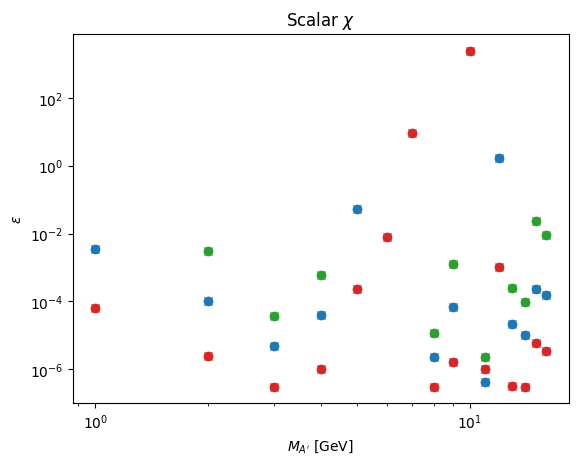

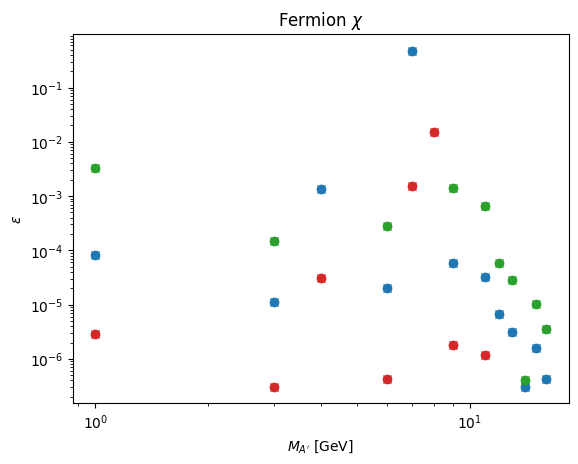

In [34]:
# Plot limits
limits_df.to_csv("../data/csv/fixed_dt.csv")
fig_scalar = plt.figure()
ax_scalar = fig_scalar.add_subplot(111)

fig_fermion = plt.figure()
ax_fermion = fig_fermion.add_subplot(111)

display(limits_df)

cols = {"0.33":"tab:red", "0.6":"tab:blue", "2.0":"tab:green"}

for dt in ["0.33", "0.6", "2.0"]:
    limits_df_loc = limits_df[limits_df["dt"]==dt+".root"]
    for row in limits_df_loc.iterrows():
        dt_ = row[1]["dt"].strip(".root")
        dmt = row[1]["dm_type"]

        if dmt == "scalar":
            ax_scalar.plot(row[1]["ma"], row[1]["obs_epsilon"], label=f"Observed, dt={dt}", color=cols[dt_], marker="o")
            ax_scalar.plot(row[1]["ma"], row[1]["exp_epsilon"], label=f"Expected, dt={dt}", color=cols[dt_], marker="x")
        
        if dmt == "fermion":
            ax_fermion.plot(row[1]["ma"], row[1]["obs_epsilon"], label="Observed", color=cols[dt_], marker="o")
            ax_fermion.plot(row[1]["ma"], row[1]["exp_epsilon"], label="Expected", color=cols[dt_], marker="x")

#ax_scalar.legend()
ax_scalar.set(title=r"Scalar $\chi$", xlabel=r"$M_{A'}$ [GeV]", ylabel=r"$\epsilon$")
ax_scalar.loglog()

#ax_fermion.legend()
ax_fermion.set(title=r"Fermion $\chi$", xlabel=r"$M_{A'}$ [GeV]", ylabel=r"$\epsilon$")
ax_fermion.loglog()

# plt.savefig("../plots/limits/fixed_dt/"+f"{row[1]['dm_type']}_dt_{dt}.png")
# plt.savefig("../plots/limits/fixed_dt/"+f"{row[1]['dm_type']}_dt_{dt}.pdf")
plt.show()

,dm_type,ma,dt,obs_epsilon,exp_epsilon,mu_obs,mu_exp
0,scalar,0.08,0.6.root,1.061105e-04,1.061105e-04,0.09595959595959595,0.09595959595959595
1,fermion,0.3,0.33.root,2.558912e-04,2.558912e-04,0.09595959595959595,0.09595959595959595
2,fermion,0.1,0.33.root,2.920773e-06,2.920773e-06,0.09595959595959595,0.09595959595959595
3,scalar,0.01,0.6.root,4.252936e-07,4.252936e-07,0.18087468391750583,0.18087468391750583
4,fermion,0.7,0.33.root,0.000000e+00,0.000000e+00,0,0


/tmp/ipykernel_35520/3371153994.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limits_df_loc["ma"] = limits_df_loc["ma"].apply(lambda x: float(x))


,dm_type,ma,dt,obs_epsilon,exp_epsilon,mu_obs,mu_exp
58,scalar,0.01,0.33.root,1.002522e-06,1.002522e-06,1.0050505050505052,1.0050505050505052
50,scalar,0.02,0.33.root,3.097735e-07,3.097735e-07,0.09595959595959595,0.09595959595959595
12,scalar,0.03,0.33.root,3.097735e-07,3.097735e-07,0.09595959595959595,0.09595959595959595
63,scalar,0.04,0.33.root,3.097770e-07,3.097770e-07,0.09596181979480461,0.09596181979480461
62,scalar,0.05,0.33.root,3.147359e-07,3.147359e-07,0.09905867361687556,0.09905867361687556
16,scalar,0.06,0.33.root,1.012918e-06,1.012918e-06,0.09595959595959595,0.09595959595959595
55,scalar,0.07,0.33.root,1.672269e-06,1.672269e-06,0.09595959595959595,0.09595959595959595
10,scalar,0.08,0.33.root,2.465336e-06,2.465336e-06,0.09595959595959595,0.09595959595959595
73,scalar,0.09,0.33.root,3.504762e-06,3.504762e-06,0.09595959595959595,0.09595959595959595
67,scalar,0.10,0.33.root,5.794750e-06,5.794750e-06,0.09595959595959595,0.09595959595959595


/tmp/ipykernel_35520/3371153994.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limits_df_loc["ma"] = limits_df_loc["ma"].apply(lambda x: float(x))


,dm_type,ma,dt,obs_epsilon,exp_epsilon,mu_obs,mu_exp
3,scalar,0.01,0.6.root,4.252936e-07,4.252936e-07,0.18087468391750583,0.18087468391750583
7,scalar,0.02,0.6.root,2.244284e-06,2.244284e-06,0.09595959595959595,0.09595959595959595
14,scalar,0.03,0.6.root,5.024966e-06,5.024966e-06,0.09595959595959595,0.09595959595959595
13,scalar,0.04,0.6.root,1.060032e-05,1.060032e-05,0.09595959595959595,0.09595959595959595
45,scalar,0.05,0.6.root,2.200162e-05,2.200162e-05,0.09595959595959595,0.09595959595959595
39,scalar,0.06,0.6.root,3.916994e-05,3.916994e-05,0.09595959595959595,0.09595959595959595
56,scalar,0.07,0.6.root,6.858047e-05,6.858047e-05,0.09595959595959595,0.09595959595959595
0,scalar,0.08,0.6.root,1.061105e-04,1.061105e-04,0.09595959595959595,0.09595959595959595
19,scalar,0.09,0.6.root,1.576825e-04,1.576825e-04,0.09595959595959595,0.09595959595959595
21,scalar,0.10,0.6.root,2.279820e-04,2.279820e-04,0.09595959595959595,0.09595959595959595


/tmp/ipykernel_35520/3371153994.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limits_df_loc["ma"] = limits_df_loc["ma"].apply(lambda x: float(x))


,dm_type,ma,dt,obs_epsilon,exp_epsilon,mu_obs,mu_exp
71,scalar,0.01,2.0.root,0.000002,0.000002,0.09595959595959595,0.09595959595959595
17,scalar,0.02,2.0.root,0.000012,0.000012,0.09595959595959595,0.09595959595959595
32,scalar,0.03,2.0.root,0.000038,0.000038,0.09595959595959595,0.09595959595959595
66,scalar,0.04,2.0.root,0.000095,0.000095,0.09595959595959595,0.09595959595959595
24,scalar,0.05,2.0.root,0.000242,0.000242,0.09595959595959595,0.09595959595959595
36,scalar,0.06,2.0.root,0.000593,0.000593,0.09595959595959595,0.09595959595959595
28,scalar,0.07,2.0.root,0.001313,0.001313,0.09595959595959595,0.09595959595959595
22,scalar,0.08,2.0.root,0.003155,0.003155,0.09595959595959595,0.09595959595959595
27,scalar,0.09,2.0.root,0.008921,0.008921,0.09595959595959595,0.09595959595959595
18,scalar,0.10,2.0.root,0.023702,0.023702,0.09595959595959595,0.09595959595959595


/tmp/ipykernel_35520/3371153994.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limits_df_loc["ma"] = limits_df_loc["ma"].apply(lambda x: float(x))


,dm_type,ma,dt,obs_epsilon,exp_epsilon,mu_obs,mu_exp
6,fermion,0.06,0.33.root,3.098291e-07,3.098291e-07,0.0959940868538702,0.0959940868538702
30,fermion,0.07,0.33.root,4.339998e-07,4.339998e-07,0.18835581610380275,0.18835581610380275
59,fermion,0.08,0.33.root,1.159802e-06,1.159802e-06,0.09595959595959595,0.09595959595959595
51,fermion,0.09,0.33.root,1.822799e-06,1.822799e-06,0.09595959595959595,0.09595959595959595
2,fermion,0.10,0.33.root,2.920773e-06,2.920773e-06,0.09595959595959595,0.09595959595959595
9,fermion,0.20,0.33.root,3.112178e-05,3.112178e-05,0.09595959595959595,0.09595959595959595
1,fermion,0.30,0.33.root,2.558912e-04,2.558912e-04,0.09595959595959595,0.09595959595959595
37,fermion,0.40,0.33.root,1.543864e-03,1.543864e-03,0.09595959595959595,0.09595959595959595
47,fermion,0.50,0.33.root,1.504343e-02,1.504343e-02,0.09595959595959595,0.09595959595959595


/tmp/ipykernel_35520/3371153994.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limits_df_loc["ma"] = limits_df_loc["ma"].apply(lambda x: float(x))


,dm_type,ma,dt,obs_epsilon,exp_epsilon,mu_obs,mu_exp
33,fermion,0.01,0.6.root,3.097735e-07,3.097735e-07,0.09595959595959595,0.09595959595959595
65,fermion,0.02,0.6.root,4.256194e-07,4.256194e-07,0.18115189146339658,0.18115189146339658
35,fermion,0.03,0.6.root,1.583826e-06,1.583826e-06,0.09595959595959595,0.09595959595959595
26,fermion,0.04,0.6.root,3.151590e-06,3.151590e-06,0.09595959595959595,0.09595959595959595
11,fermion,0.05,0.6.root,6.821581e-06,6.821581e-06,0.09595959595959595,0.09595959595959595
44,fermion,0.06,0.6.root,1.113709e-05,1.113709e-05,0.09595959595959595,0.09595959595959595
64,fermion,0.07,0.6.root,2.039193e-05,2.039193e-05,0.09595959595959595,0.09595959595959595
34,fermion,0.08,0.6.root,3.267422e-05,3.267422e-05,0.09595959595959595,0.09595959595959595
54,fermion,0.09,0.6.root,5.730834e-05,5.730834e-05,0.09595959595959595,0.09595959595959595
61,fermion,0.10,0.6.root,8.205128e-05,8.205128e-05,0.09595959595959595,0.09595959595959595


/tmp/ipykernel_35520/3371153994.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limits_df_loc["ma"] = limits_df_loc["ma"].apply(lambda x: float(x))


,dm_type,ma,dt,obs_epsilon,exp_epsilon,mu_obs,mu_exp
72,fermion,0.01,2.0.root,4.085256e-07,4.085256e-07,0.16689317546667873,0.16689317546667873
20,fermion,0.02,2.0.root,3.508771e-06,3.508771e-06,0.09595959595959595,0.09595959595959595
46,fermion,0.03,2.0.root,1.038628e-05,1.038628e-05,0.09595959595959595,0.09595959595959595
69,fermion,0.04,2.0.root,2.830904e-05,2.830904e-05,0.09595959595959595,0.09595959595959595
49,fermion,0.05,2.0.root,5.854707e-05,5.854707e-05,0.09595959595959595,0.09595959595959595
23,fermion,0.06,2.0.root,1.515885e-04,1.515885e-04,0.09595959595959595,0.09595959595959595
25,fermion,0.07,2.0.root,2.774198e-04,2.774198e-04,0.09595959595959595,0.09595959595959595
70,fermion,0.08,2.0.root,6.639310e-04,6.639310e-04,0.09595959595959595,0.09595959595959595
68,fermion,0.09,2.0.root,1.412910e-03,1.412910e-03,0.09595959595959595,0.09595959595959595
29,fermion,0.10,2.0.root,3.262663e-03,3.262663e-03,0.09595959595959595,0.09595959595959595


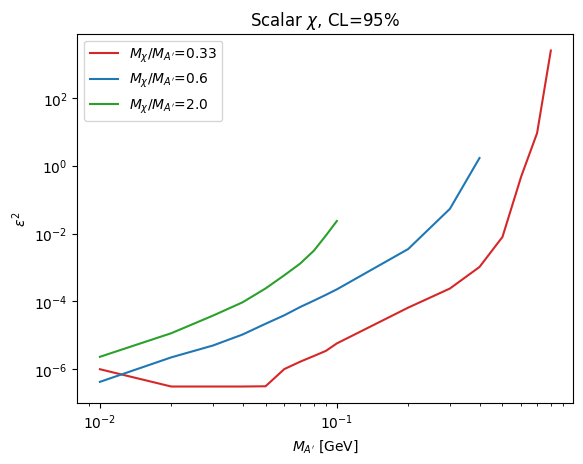

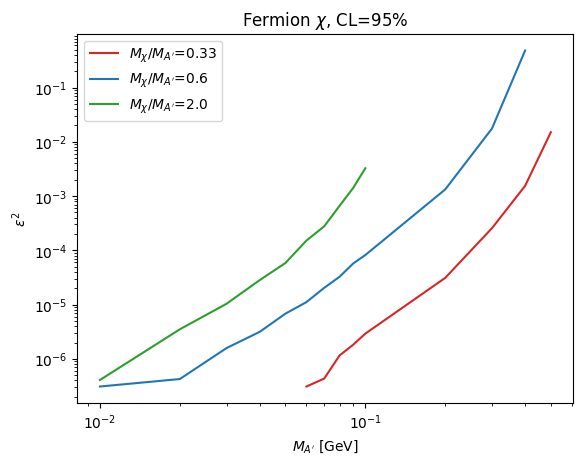

In [54]:
display(limits_df.head())

# Plot limits
limits_df.to_csv("../data/csv/fixed_dt.csv")

#display(limits_df)

cols = {"0.33":"tab:red", "0.6":"tab:blue", "2.0":"tab:green"}

for dm_type in ["scalar", "fermion"]:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for dt in ["0.33", "0.6", "2.0"]:
        limits_df_loc = limits_df[(limits_df["dt"]==dt+".root") & (limits_df["dm_type"] == dm_type)]

        limits_df_loc["ma"] = limits_df_loc["ma"].apply(lambda x: float(x))
        limits_df_loc = limits_df_loc[limits_df_loc["obs_epsilon"] > 0]
        limits_df_loc.sort_values(by="ma", inplace=True)
        display(limits_df_loc)
        ax.plot(limits_df_loc["ma"], limits_df_loc["obs_epsilon"], label=r"$M_\chi/M_{A'}$"+f"={dt}", color=cols[dt])
        #ax.scatter(limits_df_loc["ma"], limits_df_loc["exp_epsilon"], label=f"Expected, dt={dt}", color=cols[dt])
        

    #ax_scalar.legend()
    ax.set(title=f"{dm_type}".capitalize() + r" $\chi$, CL=95%", xlabel=r"$M_{A'}$ [GeV]", ylabel=r"$\epsilon^2$")
    ax.loglog()
    ax.legend()


# plt.savefig("../plots/limits/fixed_dt/"+f"{row[1]['dm_type']}_dt_{dt}.png")
# plt.savefig("../plots/limits/fixed_dt/"+f"{row[1]['dm_type']}_dt_{dt}.pdf")
plt.show()


### Fixed $M_\chi$
1) Read the .out files to check for line "in Off-Shell mode" or "in On-Shell mode"
2) for now, ignore "on shell" files (we dont know that they are handelled correctly)
3) Set Limits

In [ ]:
# Get list of data files
data_dir = "../data/root/BdNMC/fixed_Mchi/"
fnames = []
for dmt in dm_types:
    for file in os.listdir(data_dir+"/"+dmt+"/"):
        if file.endswith(".root"):
            meson = file.split("_")[0]
            ma = file.split("_")[3]
            mchi = file.split("_")[5]
            fnames.append((dmt, meson, ma, mchi, file, True))

fnames = pd.DataFrame(fnames, columns=["dm_type", "meson", "ma", "mchi", "file", "Off Shell"])

# go through the .out files
# e.g nodefixed_Mchi__pi0_scalar_ma_0.09_mchi_0.001.out
out_path = "../data/out/fixed_Mchi/"
for file in fnames:
    try:
        with open(out_path+"nodefixed_Mchi__") as f:
            for line in f:
                if "Off-Shell" in line:
                    print(line)
                    # FINISH THIS!
                elif "On-Shell" in line:
                    print(file, line)
                    fnames[file, "Off Shell"] = False # idk if this works need to check later
    except:
        print("File not found", file)
